In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-22,321.067993,334.117004,320.424988,331.885986,331.885986,22315100
1,2014-12-23,332.016998,336.286987,329.601990,334.571991,334.571991,16574200
2,2014-12-24,334.385010,334.740997,321.356995,322.533997,322.533997,15092300
3,2014-12-25,322.286011,322.670013,316.958008,319.007996,319.007996,9883640
4,2014-12-26,319.152008,331.424011,316.627014,327.924011,327.924011,16410500


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3288 entries, 0 to 3287
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3288 non-null   object 
 1   Open       3288 non-null   float64
 2   High       3288 non-null   float64
 3   Low        3288 non-null   float64
 4   Close      3288 non-null   float64
 5   Adj Close  3288 non-null   float64
 6   Volume     3288 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 179.9+ KB


In [18]:
df['Date'] = pd.to_datetime(df['Date'])

In [19]:
df.index = df['Date']

In [20]:
bitcoin_price = df["Close"]
bitcoin_price

Date
2014-12-22      331.885986
2014-12-23      334.571991
2014-12-24      322.533997
2014-12-25      319.007996
2014-12-26      327.924011
                  ...     
2023-12-18    42623.539063
2023-12-19    42270.527344
2023-12-20    43652.250000
2023-12-21    43869.152344
2023-12-22    43652.902344
Name: Close, Length: 3288, dtype: float64

Text(0, 0.5, 'Price in MAD')

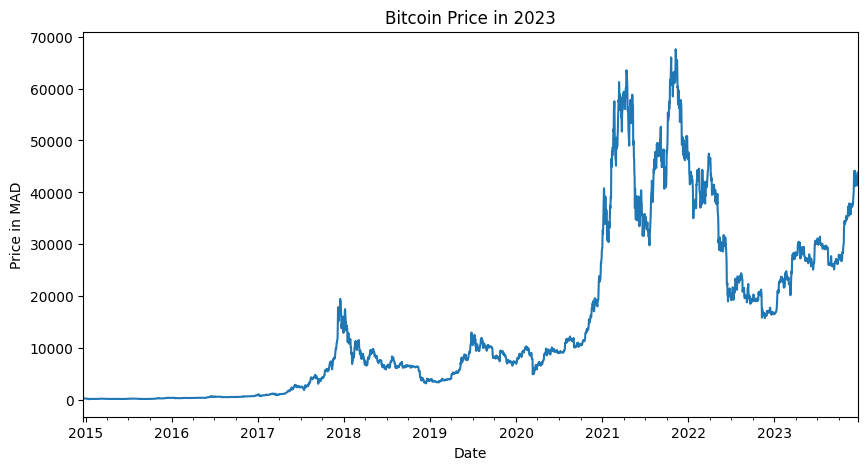

In [21]:
plt.figure(figsize=(10, 5))
bitcoin_price.plot()
plt.title("Bitcoin Price in 2023")
plt.ylabel('Price in MAD')

# Format Data Part 1: Creatining train and test sets for time series data

2630

In [28]:
split_size = 0.8
train = bitcoin_price[:int(bitcoin_price.shape[0] * 0.8)]
test = bitcoin_price[int(bitcoin_price.shape[0] * 0.8):]

Text(0.5, 1.0, 'Bitcoin Price for Train set')

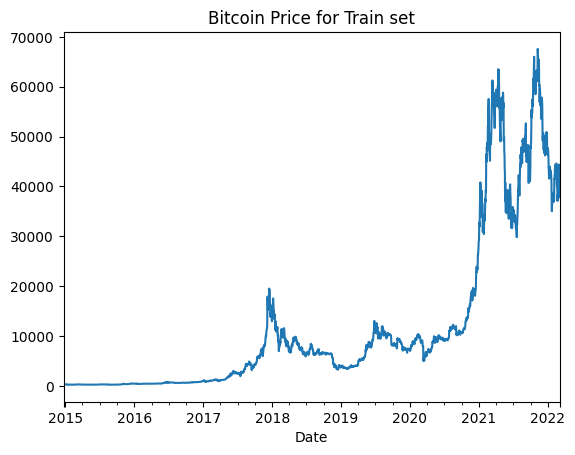

In [30]:
train.plot()
plt.title('Bitcoin Price for Train set')

Text(0.5, 1.0, 'Bitcoin Price for Test set')

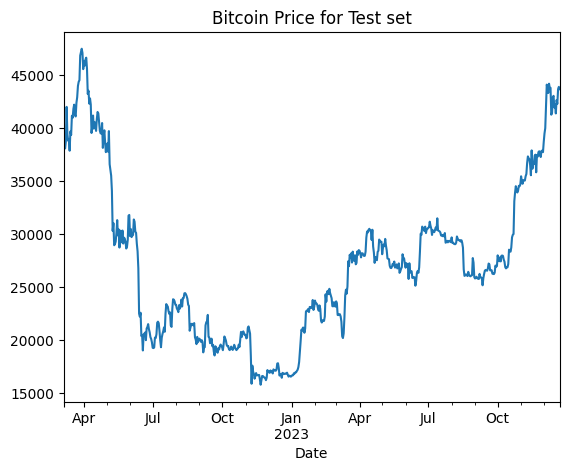

In [31]:
test.plot()
plt.title('Bitcoin Price for Test set')

In [54]:
def plot_timeseries(label, values, format='.', start=0, end=None):
    plt.plot(values.index[start:end], values.values[start:end],format,label=label)
    plt.xlabel('Date')
    plt.ylabel('Price in MAD')
    plt.legend()
    plt.grid(True)

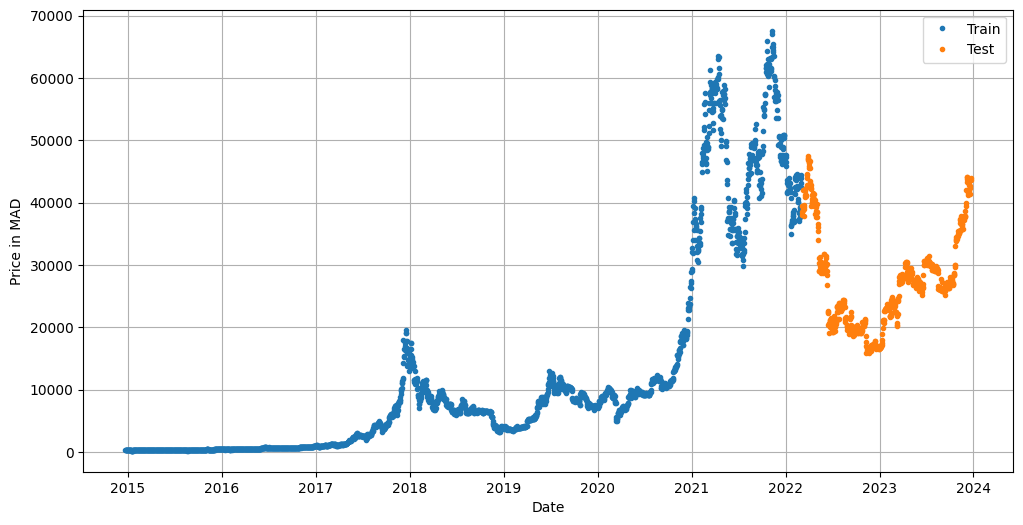

In [55]:
plt.figure(figsize=(12, 6))
plot_timeseries('Train', train)
plot_timeseries('Test', test)

## Preparing the data for Modeling

In [56]:
import tensorflow as tf

In [73]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [74]:
tf.expand_dims(tf.range(8)+1, axis=0)

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7, 8]])>

In [75]:
def get_labelled_windows(x, horizon=1):
    """
     Eg: Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [76]:
get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), HORIZON)

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]])>)

In [79]:
get_labelled_windows(tf.expand_dims(tf.range(30)+1, axis=0))

(<tf.Tensor: shape=(1, 29), dtype=int32, numpy=
 array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[30]])>)

In [283]:
def make_windows(x, window_size=7, horizon=1):
    """
    Paramtres:
    ---
    horizon : How many days we want to predict .
    x : The features (OR the past price for Bitcoin) for window_size.
    windo_size : How many feature we should use to predict the horizon.
    ---
    If window size is 5
    Eg: Input: [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]  -->
    Output : ([[1, 2, 3, 4, 5],[2, 3, 4, 5, 6],[ 3, 4, 5, 6,7], 
               [4, 5, 6, 7, 8], [5, 6, 7, 8, 9]])
    """
    win_step = np.expand_dims(np.arange(window_size+horizon),axis=0)
    win_indexes = win_step + np.expand_dims(np.arange(len(x) - (window_size  + horizon - 1)), axis=1)
    windows, labels =  get_labelled_windows(x[win_indexes])
    return windows, labels

In [301]:
windowed_prices =  make_windows(bitcoin_price.values)

In [302]:
windowed_prices

(array([[  331.885986,   334.571991,   322.533997, ...,   327.924011,
           315.863007,   317.239014],
        [  334.571991,   322.533997,   319.007996, ...,   315.863007,
           317.239014,   312.670013],
        [  322.533997,   319.007996,   327.924011, ...,   317.239014,
           312.670013,   310.737   ],
        ...,
        [42890.742188, 43023.972656, 41929.757813, ..., 41364.664063,
         42623.539063, 42270.527344],
        [43023.972656, 41929.757813, 42240.117188, ..., 42623.539063,
         42270.527344, 43652.25    ],
        [41929.757813, 42240.117188, 41364.664063, ..., 42270.527344,
         43652.25    , 43869.152344]]),
 array([[  312.670013],
        [  310.737   ],
        [  320.192993],
        ...,
        [43652.25    ],
        [43869.152344],
        [43652.902344]]))

In [303]:
windowed_prices[0].shape, windowed_prices[1].shape

((3281, 7), (3281, 1))

In [427]:
def train_test_split( x, y, split_size=0.8):
    """
    Split the entire data to test and train
    
    Parametres:
    ---
    split_size : How much the size of train in entire data 
    x: the features
    y: labels .
    """
    split_per =int(x.shape[0] * split_size)
    x_train, y_train = x[:split_per], y[:split_per]
    x_test, y_test = x[split_per:], y[split_per:]    
    return x_train, y_train, x_test, y_test

In [488]:
HORIZON = 1
WINDOW_SIZE = 7
windowed_prices =  make_windows(bitcoin_price.values, horizon=HORIZON, window_size=WINDOW_SIZE)

x, y = windowed_prices[0], windowed_prices[1]
split_size =0.8

x_train, y_train, x_test, y_test = train_test_split(split_size=split_size, x=x, y=y)
(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

(((2624, 7), (2624, 1)), ((657, 7), (657, 1)))

In [452]:
len(x_train), len(x_test), len(y_train), len(y_test)

(2624, 657, 2624, 657)

In [480]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [481]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

## Make a modelling checkpoint


In [317]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

# Model Experiments


| Model Number | Model Type | Horizon size | Window size | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA | 
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA | 
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA| 
| 10 | Same as 1 (but with Turkey 🦃 data introduced) | 1 | 7 | NA |

## Model 1: Dense model (window = 7, horizon = 1)

In [320]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

In [321]:
tf.random.set_seed(42)

In [338]:
model_1 = Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON),
], name='model_1_dense')

In [341]:
model_1.compile(loss='mae',optimizer=tf.keras.optimizers.Adam(), metrics=["mae"])

In [342]:
model_1.fit(x=x_train, 
            y=y_train, 
            epochs=100, 
            callbacks=[create_model_checkpoint(model_1.name)],
            validation_data=(x_test, y_test), 
            batch_size=128, 
            verbose=1)

Epoch 1/100
21/21 [==============================] - 2s 58ms/step - loss: 859.4890 - mae: 859.4890 - val_loss: 1143.8770 - val_mae: 1143.8770
Epoch 2/100
21/21 [==============================] - 1s 71ms/step - loss: 636.5235 - mae: 636.5235 - val_loss: 884.3668 - val_mae: 884.3668
Epoch 3/100
21/21 [==============================] - 1s 57ms/step - loss: 577.2198 - mae: 577.2198 - val_loss: 862.2236 - val_mae: 862.2236
Epoch 4/100
21/21 [==============================] - 1s 59ms/step - loss: 547.0763 - mae: 547.0763 - val_loss: 851.7880 - val_mae: 851.7880
Epoch 5/100
21/21 [==============================] - 1s 66ms/step - loss: 510.4744 - mae: 510.4744 - val_loss: 796.4995 - val_mae: 796.4995
Epoch 6/100
21/21 [==============================] - 2s 75ms/step - loss: 489.8975 - mae: 489.8975 - val_loss: 680.2600 - val_mae: 680.2600
Epoch 7/100
21/21 [==============================] - 0s 6ms/step - loss: 501.9981 - mae: 501.9981 - val_loss: 787.9048 - val_mae: 787.9048
Epoch 8/100
21/21 [

21/21 [==============================] - 2s 75ms/step - loss: 368.3811 - mae: 368.3811 - val_loss: 518.9203 - val_mae: 518.9203
Epoch 44/100
21/21 [==============================] - 0s 7ms/step - loss: 382.1328 - mae: 382.1328 - val_loss: 545.6602 - val_mae: 545.6602
Epoch 45/100
21/21 [==============================] - 0s 16ms/step - loss: 369.6514 - mae: 369.6514 - val_loss: 636.6260 - val_mae: 636.6260
Epoch 46/100
21/21 [==============================] - 2s 82ms/step - loss: 368.7597 - mae: 368.7597 - val_loss: 516.3237 - val_mae: 516.3237
Epoch 47/100
21/21 [==============================] - 0s 7ms/step - loss: 368.4801 - mae: 368.4801 - val_loss: 713.9843 - val_mae: 713.9843
Epoch 48/100
21/21 [==============================] - 0s 5ms/step - loss: 390.2771 - mae: 390.2771 - val_loss: 562.8761 - val_mae: 562.8761
Epoch 49/100
21/21 [==============================] - 0s 6ms/step - loss: 378.4651 - mae: 378.4651 - val_loss: 554.6227 - val_mae: 554.6227
Epoch 50/100
21/21 [==========

Epoch 94/100
21/21 [==============================] - 2s 100ms/step - loss: 364.0595 - mae: 364.0595 - val_loss: 501.2848 - val_mae: 501.2848
Epoch 95/100
21/21 [==============================] - 0s 5ms/step - loss: 382.8308 - mae: 382.8308 - val_loss: 1052.7002 - val_mae: 1052.7002
Epoch 96/100
21/21 [==============================] - 0s 6ms/step - loss: 387.0606 - mae: 387.0606 - val_loss: 816.1005 - val_mae: 816.1005
Epoch 97/100
21/21 [==============================] - 0s 5ms/step - loss: 406.3619 - mae: 406.3619 - val_loss: 564.1959 - val_mae: 564.1959
Epoch 98/100
21/21 [==============================] - 0s 6ms/step - loss: 366.8982 - mae: 366.8982 - val_loss: 610.2915 - val_mae: 610.2915
Epoch 99/100
21/21 [==============================] - 0s 6ms/step - loss: 359.3134 - mae: 359.3134 - val_loss: 507.5132 - val_mae: 507.5132
Epoch 100/100
21/21 [==============================] - 0s 13ms/step - loss: 360.5023 - mae: 360.5023 - val_loss: 541.6064 - val_mae: 541.6064


In [343]:
model_1.evaluate(x_test, y_test)

21/21 [==============================] - 0s 3ms/step - loss: 541.6064 - mae: 541.6064


[541.6063842773438, 541.6063842773438]

In [408]:
def make_pred(x, model):
    """  
    Forcasting function 

    Parametres:    
    ----
    
    x : the samples you want to forcast.
    model:  the model you want to use  to perform the prediction.
    """
    return tf.squeeze(model.predict(x))

In [489]:
pred = make_pred(x_test,model_1)

21/21 [==============================] - 1s 7ms/step


In [492]:
pred.shape, x_test.shape

(TensorShape([657]), (657, 7))

In [493]:
pred

<tf.Tensor: shape=(657,), dtype=float32, numpy=
array([38892.117, 38054.18 , 37657.71 , 38250.08 , 41437.58 , 39449.39 ,
       38610.61 , 38648.89 , 37707.527, 38940.223, 39148.953, 40691.977,
       40702.293, 41544.332, 41829.79 , 41145.348, 40726.78 , 41930.836,
       42517.   , 43518.65 , 44073.23 , 44262.113, 46262.152, 46852.508,
       47135.312, 46816.992, 45443.312, 45754.312, 45537.77 , 45988.29 ,
       46225.08 , 45404.367, 43061.43 , 43117.348, 41995.797, 42274.336,
       41866.344, 39538.156, 39660.133, 40737.8  , 39698.992, 40096.86 ,
       40245.453, 39495.906, 40315.688, 41193.84 , 41084.23 , 40321.29 ,
       39573.19 , 39159.07 , 39097.137, 39995.516, 38076.2  , 38802.996,
       39419.32 , 38465.188, 37399.168, 38173.418, 38190.305, 37478.74 ,
       39198.484, 36704.3  , 35767.414, 35224.605, 33942.383, 30219.89 ,
       30757.53 , 28802.258, 28638.795, 28886.19 , 29892.67 , 30873.775,
       29910.83 , 30157.564, 28706.273, 29883.332, 29008.549, 29222.535,
   

In [494]:
model_1_results = evaluate_preds(tf.squeeze(y_test),pred)
model_1_results

{'mae': 541.6064,
 'mse': 634013.0,
 'rmse': 796.2493,
 'mape': 1.9863317,
 'mase': 1.0821626}

In [358]:
def plot_timeseries(label, values,y, format='.', start=0, end=None):
    plt.plot(values[start:end], y[start:end],format,label=label)
    plt.xlabel('Date')
    plt.ylabel('Price in MAD')
    plt.legend()
    plt.grid(True)

In [391]:
pred

<tf.Tensor: shape=(657,), dtype=float32, numpy=
array([38892.117, 38054.18 , 37657.71 , 38250.08 , 41437.58 , 39449.39 ,
       38610.61 , 38648.89 , 37707.527, 38940.223, 39148.953, 40691.977,
       40702.293, 41544.332, 41829.79 , 41145.348, 40726.78 , 41930.836,
       42517.   , 43518.65 , 44073.23 , 44262.113, 46262.152, 46852.508,
       47135.312, 46816.992, 45443.312, 45754.312, 45537.77 , 45988.29 ,
       46225.08 , 45404.367, 43061.43 , 43117.348, 41995.797, 42274.336,
       41866.344, 39538.156, 39660.133, 40737.8  , 39698.992, 40096.86 ,
       40245.453, 39495.906, 40315.688, 41193.84 , 41084.23 , 40321.29 ,
       39573.19 , 39159.07 , 39097.137, 39995.516, 38076.2  , 38802.996,
       39419.32 , 38465.188, 37399.168, 38173.418, 38190.305, 37478.74 ,
       39198.484, 36704.3  , 35767.414, 35224.605, 33942.383, 30219.89 ,
       30757.53 , 28802.258, 28638.795, 28886.19 , 29892.67 , 30873.775,
       29910.83 , 30157.564, 28706.273, 29883.332, 29008.549, 29222.535,
   

In [459]:
timesteps_test =  np.array(test.index)[-len(x_test):]

In [456]:
timesteps_test.shape

(652,)

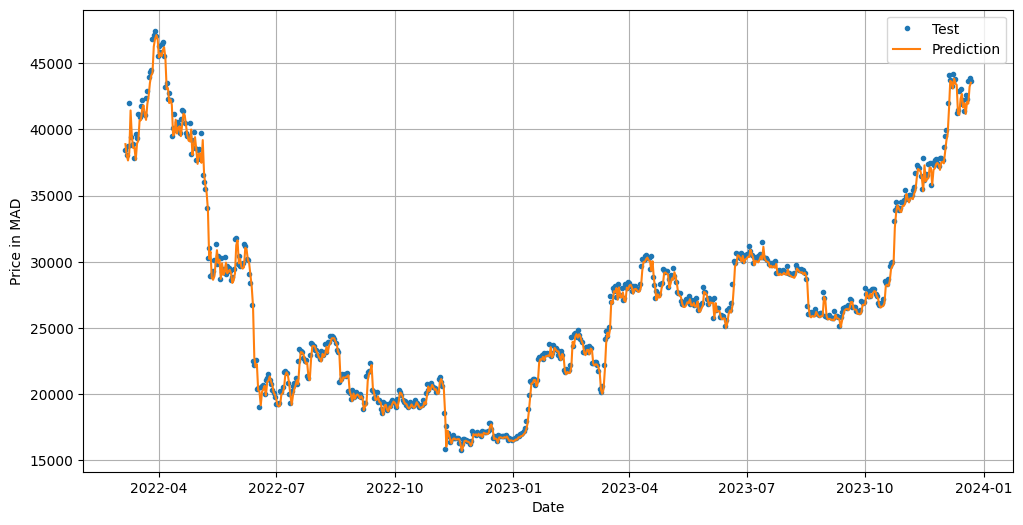

In [460]:
plt.figure(figsize=(12,6))
plot_timeseries("Test" ,
                timesteps_test, np.array(tf.squeeze(y_test)),format='.', start=0, end=None)
plot_timeseries("Prediction" ,
                timesteps_test, np.array(pred),format='-', start=0, end=None)

## Model 2: Dense (window = 30, horizon = 1)

In [496]:
HORIZON = 1
WINDOW_SIZE = 30
windowed_prices =  make_windows(bitcoin_price.values, horizon=HORIZON, window_size=WINDOW_SIZE)

x, y = windowed_prices[0], windowed_prices[1]
split_size =0.8

x_train, y_train, x_test, y_test = train_test_split(split_size=split_size, x=x, y=y)
(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

(((2606, 30), (2606, 1)), ((652, 30), (652, 1)))

In [429]:

tf.random.set_seed(42)
model_2 = Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON),
], name='model_2_dense')
model_2.compile(loss='mae',optimizer=tf.keras.optimizers.Adam(), metrics=["mae"])
model_2.fit(x=x_train, 
            y=y_train, 
            epochs=100, 
            callbacks=[create_model_checkpoint(model_2.name)],
            validation_data=(x_test, y_test), 
            batch_size=128, 
            verbose=1)

Epoch 1/100
21/21 [==============================] - 2s 80ms/step - loss: 4904.0581 - mae: 4904.0581 - val_loss: 4983.7139 - val_mae: 4983.7139
Epoch 2/100
21/21 [==============================] - 2s 79ms/step - loss: 1415.4253 - mae: 1415.4253 - val_loss: 2270.8511 - val_mae: 2270.8511
Epoch 3/100
21/21 [==============================] - 1s 65ms/step - loss: 925.2394 - mae: 925.2394 - val_loss: 1201.8671 - val_mae: 1201.8671
Epoch 4/100
21/21 [==============================] - 1s 72ms/step - loss: 784.8245 - mae: 784.8245 - val_loss: 1081.4895 - val_mae: 1081.4895
Epoch 5/100
21/21 [==============================] - 1s 56ms/step - loss: 767.8583 - mae: 767.8583 - val_loss: 1059.6215 - val_mae: 1059.6215
Epoch 6/100
21/21 [==============================] - 1s 59ms/step - loss: 701.1231 - mae: 701.1231 - val_loss: 1003.6198 - val_mae: 1003.6198
Epoch 7/100
21/21 [==============================] - 2s 75ms/step - loss: 656.6412 - mae: 656.6412 - val_loss: 938.3378 - val_mae: 938.3378
Epoc

21/21 [==============================] - 1s 63ms/step - loss: 441.1830 - mae: 441.1830 - val_loss: 579.4852 - val_mae: 579.4852
Epoch 44/100
21/21 [==============================] - 0s 5ms/step - loss: 426.4772 - mae: 426.4772 - val_loss: 607.0555 - val_mae: 607.0555
Epoch 45/100
21/21 [==============================] - 0s 7ms/step - loss: 428.7056 - mae: 428.7056 - val_loss: 765.0527 - val_mae: 765.0527
Epoch 46/100
21/21 [==============================] - 0s 8ms/step - loss: 445.7176 - mae: 445.7176 - val_loss: 624.9995 - val_mae: 624.9995
Epoch 47/100
21/21 [==============================] - 0s 13ms/step - loss: 438.8356 - mae: 438.8356 - val_loss: 1028.1497 - val_mae: 1028.1497
Epoch 48/100
21/21 [==============================] - 0s 6ms/step - loss: 513.4934 - mae: 513.4934 - val_loss: 761.1525 - val_mae: 761.1525
Epoch 49/100
21/21 [==============================] - 0s 6ms/step - loss: 550.2279 - mae: 550.2279 - val_loss: 867.6392 - val_mae: 867.6392
Epoch 50/100
21/21 [=========

21/21 [==============================] - 2s 78ms/step - loss: 383.4057 - mae: 383.4057 - val_loss: 511.7320 - val_mae: 511.7320
Epoch 94/100
21/21 [==============================] - 0s 6ms/step - loss: 380.0397 - mae: 380.0397 - val_loss: 757.0120 - val_mae: 757.0120
Epoch 95/100
21/21 [==============================] - 0s 5ms/step - loss: 377.8802 - mae: 377.8802 - val_loss: 908.3102 - val_mae: 908.3102
Epoch 96/100
21/21 [==============================] - 0s 6ms/step - loss: 401.1406 - mae: 401.1406 - val_loss: 528.9490 - val_mae: 528.9490
Epoch 97/100
21/21 [==============================] - 0s 6ms/step - loss: 379.9553 - mae: 379.9553 - val_loss: 613.1210 - val_mae: 613.1210
Epoch 98/100
21/21 [==============================] - 0s 6ms/step - loss: 399.5801 - mae: 399.5801 - val_loss: 768.6442 - val_mae: 768.6442
Epoch 99/100
21/21 [==============================] - 0s 11ms/step - loss: 438.5334 - mae: 438.5334 - val_loss: 1016.5353 - val_mae: 1016.5353
Epoch 100/100
21/21 [========

In [431]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(x_test, y_test)

21/21 [==============================] - 0s 3ms/step - loss: 511.7319 - mae: 511.7319


[511.73187255859375, 511.73187255859375]

In [497]:
pred = make_pred(x_test, model_2)

21/21 [==============================] - 0s 3ms/step


In [499]:
model_2_results = evaluate_preds(tf.squeeze(y_test),pred)
model_2_results

{'mae': 511.73196,
 'mse': 601740.3,
 'rmse': 775.71924,
 'mape': 1.9157727,
 'mase': 1.0382919}

In [463]:

timesteps_test =  np.array(test.index)[-len(x_test):]

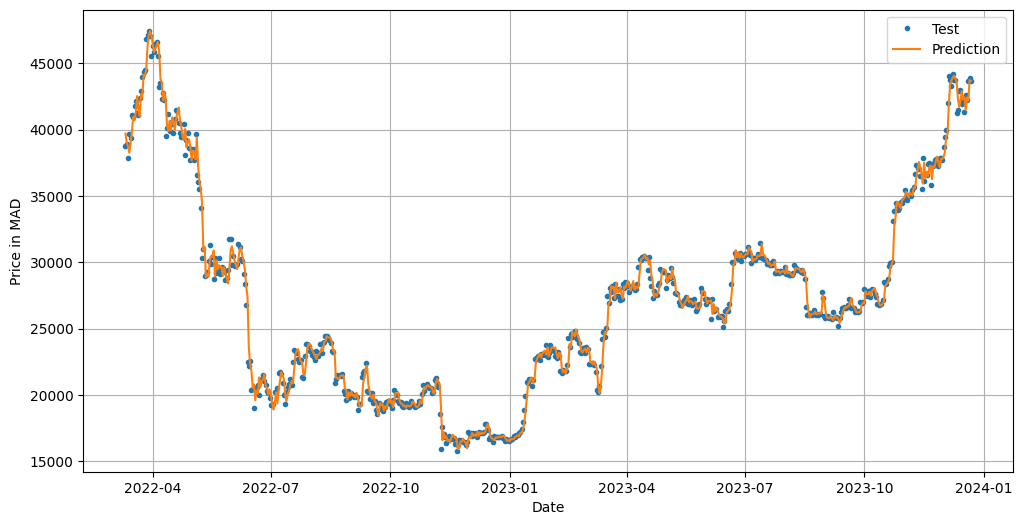

In [464]:
plt.figure(figsize=(12,6))
plot_timeseries("Test" ,
                timesteps_test[-len(x_test):], np.array(tf.squeeze(y_test)),format='.', start=0, end=None)
plot_timeseries("Prediction" ,
                timesteps_test[-len(x_test):], np.array(tf.squeeze(pred)),format='-', start=0, end=None)

In [436]:
timesteps_test

array(['2022-03-06T00:00:00.000000000', '2022-03-07T00:00:00.000000000',
       '2022-03-08T00:00:00.000000000', '2022-03-09T00:00:00.000000000',
       '2022-03-10T00:00:00.000000000', '2022-03-11T00:00:00.000000000',
       '2022-03-12T00:00:00.000000000', '2022-03-13T00:00:00.000000000',
       '2022-03-14T00:00:00.000000000', '2022-03-15T00:00:00.000000000',
       '2022-03-16T00:00:00.000000000', '2022-03-17T00:00:00.000000000',
       '2022-03-18T00:00:00.000000000', '2022-03-19T00:00:00.000000000',
       '2022-03-20T00:00:00.000000000', '2022-03-21T00:00:00.000000000',
       '2022-03-22T00:00:00.000000000', '2022-03-23T00:00:00.000000000',
       '2022-03-24T00:00:00.000000000', '2022-03-25T00:00:00.000000000',
       '2022-03-26T00:00:00.000000000', '2022-03-27T00:00:00.000000000',
       '2022-03-28T00:00:00.000000000', '2022-03-29T00:00:00.000000000',
       '2022-03-30T00:00:00.000000000', '2022-03-31T00:00:00.000000000',
       '2022-04-01T00:00:00.000000000', '2022-04-02

## Model 3: Dense (window = 30, horizon = 7)


In [500]:
HORIZON = 7
WINDOW_SIZE = 30
windowed_prices =  make_windows(bitcoin_price.values, horizon=HORIZON, window_size=WINDOW_SIZE)

x, y = windowed_prices[0], windowed_prices[1]
split_size =0.8

x_train, y_train, x_test, y_test = train_test_split(split_size=split_size, x=x, y=y)
(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

(((2601, 36), (2601, 1)), ((651, 36), (651, 1)))

In [479]:
y_train

array([[  263.475006],
       [  233.914993],
       [  233.513   ],
       ...,
       [41982.925781],
       [39437.460938],
       [38794.972656]])

In [466]:

model_3 = Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON),
], name='model_3_dense')
model_3.compile(loss='mae',optimizer=tf.keras.optimizers.Adam(), metrics=["mae"])
model_3.fit(x=x_train, 
            y=y_train, 
            epochs=100, 
            callbacks=[create_model_checkpoint(model_3.name)],
            validation_data=(x_test, y_test), 
            batch_size=128, 
            verbose=1)

Epoch 1/100
21/21 [==============================] - 2s 68ms/step - loss: 6020.5151 - mae: 6020.5151 - val_loss: 3112.5471 - val_mae: 3112.5471
Epoch 2/100
21/21 [==============================] - 1s 62ms/step - loss: 1445.5364 - mae: 1445.5364 - val_loss: 2008.1313 - val_mae: 2008.1313
Epoch 3/100
21/21 [==============================] - 1s 67ms/step - loss: 1075.9718 - mae: 1075.9718 - val_loss: 1559.8552 - val_mae: 1559.8552
Epoch 4/100
21/21 [==============================] - 2s 92ms/step - loss: 924.9628 - mae: 924.9628 - val_loss: 1330.7587 - val_mae: 1330.7587
Epoch 5/100
21/21 [==============================] - 2s 94ms/step - loss: 843.1625 - mae: 843.1625 - val_loss: 1297.6757 - val_mae: 1297.6757
Epoch 6/100
21/21 [==============================] - 1s 71ms/step - loss: 815.5114 - mae: 815.5114 - val_loss: 1271.7260 - val_mae: 1271.7260
Epoch 7/100
21/21 [==============================] - 1s 75ms/step - loss: 777.6807 - mae: 777.6807 - val_loss: 1154.1746 - val_mae: 1154.1746


21/21 [==============================] - 1s 72ms/step - loss: 493.2309 - mae: 493.2309 - val_loss: 723.1819 - val_mae: 723.1819
Epoch 41/100
21/21 [==============================] - 0s 8ms/step - loss: 521.4865 - mae: 521.4865 - val_loss: 815.9655 - val_mae: 815.9655
Epoch 42/100
21/21 [==============================] - 1s 71ms/step - loss: 484.8057 - mae: 484.8057 - val_loss: 696.6713 - val_mae: 696.6713
Epoch 43/100
21/21 [==============================] - 0s 7ms/step - loss: 486.7146 - mae: 486.7146 - val_loss: 700.0975 - val_mae: 700.0975
Epoch 44/100
21/21 [==============================] - 0s 7ms/step - loss: 479.7285 - mae: 479.7285 - val_loss: 723.2571 - val_mae: 723.2571
Epoch 45/100
21/21 [==============================] - 0s 7ms/step - loss: 479.1005 - mae: 479.1005 - val_loss: 753.9214 - val_mae: 753.9214
Epoch 46/100
21/21 [==============================] - 0s 6ms/step - loss: 482.4916 - mae: 482.4916 - val_loss: 698.7201 - val_mae: 698.7201
Epoch 47/100
21/21 [===========

Epoch 88/100
21/21 [==============================] - 0s 7ms/step - loss: 424.3674 - mae: 424.3674 - val_loss: 724.8894 - val_mae: 724.8894
Epoch 89/100
21/21 [==============================] - 0s 6ms/step - loss: 413.2657 - mae: 413.2657 - val_loss: 618.7729 - val_mae: 618.7729
Epoch 90/100
21/21 [==============================] - 0s 7ms/step - loss: 412.0699 - mae: 412.0699 - val_loss: 679.8375 - val_mae: 679.8375
Epoch 91/100
21/21 [==============================] - 0s 6ms/step - loss: 425.5974 - mae: 425.5974 - val_loss: 984.0737 - val_mae: 984.0737
Epoch 92/100
21/21 [==============================] - 0s 6ms/step - loss: 440.6099 - mae: 440.6099 - val_loss: 604.6941 - val_mae: 604.6941
Epoch 93/100
21/21 [==============================] - 0s 8ms/step - loss: 417.2244 - mae: 417.2244 - val_loss: 763.2749 - val_mae: 763.2749
Epoch 94/100
21/21 [==============================] - 0s 7ms/step - loss: 449.9421 - mae: 449.9421 - val_loss: 995.6143 - val_mae: 995.6143
Epoch 95/100
21/21 [

In [467]:
# Load in best performing model
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(x_test, y_test)

21/21 [==============================] - 0s 3ms/step - loss: 573.7558 - mae: 573.7558


[573.7557983398438, 573.7557983398438]

In [501]:
pred = make_pred(x_test, model_3)
timesteps_test =  np.array(test.index)[-len(x_test):]

21/21 [==============================] - 0s 3ms/step


In [475]:
pred

<tf.Tensor: shape=(651, 7), dtype=float32, numpy=
array([[40110.727, 39451.37 , 38460.66 , ..., 38872.52 , 39282.23 ,
        39193.46 ],
       [39826.965, 37687.09 , 39105.81 , ..., 38800.08 , 39314.57 ,
        39722.47 ],
       [38032.105, 37609.35 , 38760.844, ..., 37706.77 , 38485.723,
        38024.367],
       ...,
       [42416.61 , 41270.56 , 41951.547, ..., 41656.754, 42219.96 ,
        42259.31 ],
       [43937.812, 43027.598, 43191.2  , ..., 43379.355, 43723.8  ,
        43266.707],
       [43716.996, 43345.71 , 43861.543, ..., 43743.582, 43859.62 ,
        43739.254]], dtype=float32)>

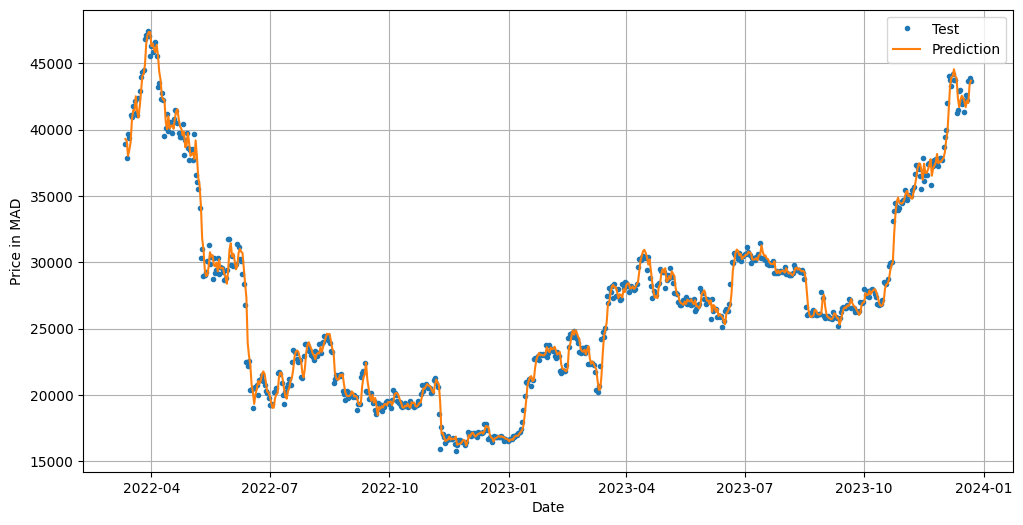

In [483]:
plt.figure(figsize=(12,6))
plot_timeseries("Test" ,
                timesteps_test, np.array(tf.squeeze(y_test)),format='.', start=0, end=None)
plot_timeseries("Prediction" ,
                timesteps_test, tf.reduce_mean(pred, axis=1), format='-', start=0, end=None)

In [502]:
evaluate_preds(y_test,tf.reduce_mean(pred, axis=1) )

{'mae': array([12584.131 , 11759.991 , 13199.756 , 12932.973 , 14444.182 ,
        14277.882 , 15019.399 , 15367.684 , 14534.034 , 14387.16  ,
        15520.279 , 16013.11  , 17010.941 , 17381.725 , 17528.164 ,
        19789.148 , 20093.826 , 20430.016 , 20029.09  , 18532.775 ,
        19256.992 , 18853.781 , 19425.83  , 19593.156 , 18549.56  ,
        16304.614 , 16581.734 , 15455.475 , 15910.461 , 15383.006 ,
        13081.771 , 13578.96  , 14463.9   , 13420.16  , 13938.364 ,
        13829.195 , 13240.7   , 14170.329 , 14755.494 , 14643.493 ,
        13916.2705, 13259.762 , 13053.19  , 13039.021 , 13857.823 ,
        11965.548 , 12853.769 , 13287.169 , 12351.246 , 11657.991 ,
        12240.359 , 12287.813 , 11684.757 , 13225.545 , 10832.667 ,
        10460.144 , 10088.678 ,  9132.477 ,  6787.2183,  7203.2666,
         6214.907 ,  6249.6265,  6328.3945,  6688.787 ,  7379.7637,
         6574.98  ,  6854.961 ,  6150.416 ,  6796.284 ,  6299.505 ,
         6385.396 ,  6801.2026,  6265.893

In [505]:
tf.reduce_mean(pred, axis=1)

<tf.Tensor: shape=(651,), dtype=float32, numpy=
array([39292.812 , 39153.91  , 38026.5   , 38473.27  , 39049.625 ,
       40740.242 , 41480.176 , 41447.008 , 42519.26  , 41389.918 ,
       40914.52  , 41754.527 , 42928.48  , 44034.992 , 44216.273 ,
       44881.    , 46488.03  , 47151.473 , 47368.91  , 47364.207 ,
       46304.223 , 46492.91  , 46066.895 , 45846.81  , 46402.895 ,
       45605.062 , 44364.555 , 43778.605 , 42534.324 , 42268.098 ,
       42256.7   , 40593.72  , 40042.457 , 41022.895 , 40088.926 ,
       40270.508 , 40331.777 , 40076.242 , 40839.    , 41370.137 ,
       41547.305 , 40781.996 , 40234.918 , 40074.117 , 39576.402 ,
       39841.76  , 38683.695 , 38779.55  , 39748.746 , 38989.402 ,
       38024.285 , 38147.562 , 38248.34  , 37791.59  , 39191.625 ,
       37920.23  , 36383.254 , 35824.207 , 34325.215 , 31785.963 ,
       30994.234 , 29450.662 , 28957.973 , 29020.756 , 29687.326 ,
       30764.072 , 30432.791 , 30533.293 , 29771.006 , 29692.887 ,
       29976.8

In [506]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [510]:
model_3_results = evaluate_preds(y_test,tf.reduce_mean(pred, axis=1) )

In [512]:
model_3_results

{'mae': 8246.829,
 'mse': 110514410.0,
 'rmse': 10061.171,
 'mape': 31.827276,
 'mase': 16.712597}

In [514]:
model_2_results

{'mae': 511.73196,
 'mse': 601740.3,
 'rmse': 775.71924,
 'mape': 1.9157727,
 'mase': 1.0382919}

In [515]:
model_1_results

{'mae': 541.6064,
 'mse': 634013.0,
 'rmse': 796.2493,
 'mape': 1.9863317,
 'mase': 1.0821626}

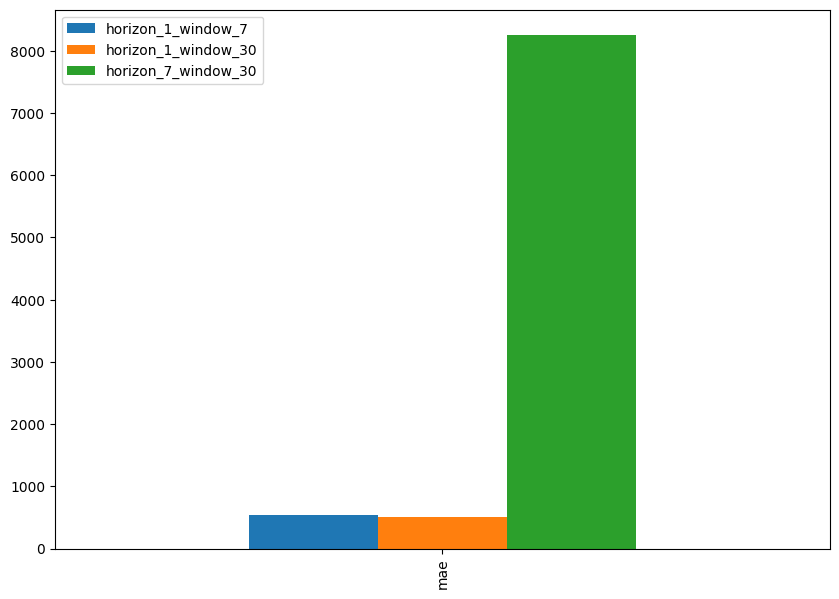

In [513]:
pd.DataFrame({
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

## Model 4 :Conv1D

In [517]:
HORIZON = 1
WINDOW_SIZE = 7
windowed_prices =  make_windows(bitcoin_price.values, horizon=HORIZON, window_size=WINDOW_SIZE)

x, y = windowed_prices[0], windowed_prices[1]
split_size =0.8

x_train, y_train, x_test, y_test = train_test_split(split_size=split_size, x=x, y=y)
(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

(((2624, 7), (2624, 1)), ((657, 7), (657, 1)))

In [518]:
tf.constant(x_train[0])

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([331.885986, 334.571991, 322.533997, 319.007996, 327.924011,
       315.863007, 317.239014])>

In [521]:
x_train[0]

array([331.885986, 334.571991, 322.533997, 319.007996, 327.924011,
       315.863007, 317.239014])

In [523]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

In [524]:
expand_dims_layer(x_train[0])

<tf.Tensor: shape=(7, 1), dtype=float32, numpy=
array([[331.886],
       [334.572],
       [322.534],
       [319.008],
       [327.924],
       [315.863],
       [317.239]], dtype=float32)>

In [525]:
tf.expand_dims(x_train[0], axis=1)

<tf.Tensor: shape=(7, 1), dtype=float64, numpy=
array([[331.885986],
       [334.571991],
       [322.533997],
       [319.007996],
       [327.924011],
       [315.863007],
       [317.239014]])>

In [529]:
model_4 = Sequential([
    layers.Lambda(lambda x:tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, padding='causal', activation='relu'),
    layers.Dense(HORIZON),
],  name='model_4_dense')

In [531]:
model_4.compile(loss='mae',
             optimizer=tf.keras.optimizers.Adam())

In [533]:
model_4.fit(x = x_train, 
            y = y_train, 
            validation_data=(x_test, y_test), 
            batch_size=128, epochs=100,
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
12/21 [================>.............] - ETA: 0s - loss: 389.4940

INFO:tensorflow:Assets written to: model_experiments\model_4_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_dense\assets


21/21 [==============================] - 5s 255ms/step - loss: 363.0383 - val_loss: 526.5818
Epoch 2/100
21/21 [==============================] - 0s 12ms/step - loss: 363.5437 - val_loss: 630.3034
Epoch 3/100
21/21 [==============================] - 0s 7ms/step - loss: 360.8123 - val_loss: 694.9880
Epoch 4/100
21/21 [==============================] - 0s 8ms/step - loss: 385.0874 - val_loss: 796.6570
Epoch 5/100
21/21 [==============================] - 0s 10ms/step - loss: 415.3099 - val_loss: 555.2479
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 360.4366 - val_loss: 544.2764
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 355.5588 - val_loss: 536.5173
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 354.0968 - val_loss: 542.9467
Epoch 9/100
15/21 [====================>.........] - ETA: 0s - loss: 358.9940

INFO:tensorflow:Assets written to: model_experiments\model_4_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_dense\assets


21/21 [==============================] - 3s 169ms/step - loss: 354.3115 - val_loss: 522.7997
Epoch 10/100
21/21 [==============================] - 0s 13ms/step - loss: 356.2916 - val_loss: 563.9501
Epoch 11/100
15/21 [====================>.........] - ETA: 0s - loss: 354.3654

INFO:tensorflow:Assets written to: model_experiments\model_4_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_dense\assets


21/21 [==============================] - 3s 143ms/step - loss: 351.1825 - val_loss: 504.9319
Epoch 12/100
21/21 [==============================] - 1s 26ms/step - loss: 351.2974 - val_loss: 643.3611
Epoch 13/100
21/21 [==============================] - 0s 8ms/step - loss: 369.9438 - val_loss: 508.2992
Epoch 14/100
21/21 [==============================] - 0s 7ms/step - loss: 354.0586 - val_loss: 534.2613
Epoch 15/100
21/21 [==============================] - 0s 6ms/step - loss: 355.2493 - val_loss: 559.5276
Epoch 16/100
21/21 [==============================] - 0s 6ms/step - loss: 367.4986 - val_loss: 536.3752
Epoch 17/100
21/21 [==============================] - 0s 7ms/step - loss: 358.7573 - val_loss: 518.0159
Epoch 18/100
21/21 [==============================] - 0s 9ms/step - loss: 349.2492 - val_loss: 580.6435
Epoch 19/100
21/21 [==============================] - 0s 6ms/step - loss: 357.2146 - val_loss: 539.9234
Epoch 20/100
21/21 [==============================] - 0s 6ms/step - loss: 

INFO:tensorflow:Assets written to: model_experiments\model_4_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_dense\assets


21/21 [==============================] - 2s 109ms/step - loss: 381.2575 - val_loss: 503.4348
Epoch 27/100
21/21 [==============================] - 0s 11ms/step - loss: 355.7854 - val_loss: 511.1840
Epoch 28/100
21/21 [==============================] - 0s 8ms/step - loss: 357.7772 - val_loss: 524.0557
Epoch 29/100
21/21 [==============================] - 0s 8ms/step - loss: 355.6254 - val_loss: 519.0974
Epoch 30/100
21/21 [==============================] - 0s 9ms/step - loss: 350.8493 - val_loss: 503.7547
Epoch 31/100
21/21 [==============================] - 0s 9ms/step - loss: 352.2772 - val_loss: 513.8081
Epoch 32/100
21/21 [==============================] - 0s 16ms/step - loss: 351.2539 - val_loss: 506.0789
Epoch 33/100
21/21 [==============================] - 0s 10ms/step - loss: 356.8969 - val_loss: 536.2335
Epoch 34/100
21/21 [==============================] - 0s 7ms/step - loss: 353.0778 - val_loss: 577.0324
Epoch 35/100
21/21 [==============================] - 0s 7ms/step - loss

INFO:tensorflow:Assets written to: model_experiments\model_4_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_dense\assets


21/21 [==============================] - 2s 92ms/step - loss: 351.5135 - val_loss: 501.8627
Epoch 39/100
21/21 [==============================] - 0s 9ms/step - loss: 351.6957 - val_loss: 546.6791
Epoch 40/100
21/21 [==============================] - 0s 10ms/step - loss: 393.9037 - val_loss: 728.7971
Epoch 41/100
21/21 [==============================] - 0s 14ms/step - loss: 361.9166 - val_loss: 535.1423
Epoch 42/100
21/21 [==============================] - 0s 10ms/step - loss: 355.9745 - val_loss: 615.8362
Epoch 43/100
21/21 [==============================] - 0s 7ms/step - loss: 362.1979 - val_loss: 604.9731
Epoch 44/100
21/21 [==============================] - 0s 12ms/step - loss: 378.3818 - val_loss: 513.5765
Epoch 45/100
21/21 [==============================] - 0s 11ms/step - loss: 356.0453 - val_loss: 541.0970
Epoch 46/100
21/21 [==============================] - ETA: 0s - loss: 347.6730

INFO:tensorflow:Assets written to: model_experiments\model_4_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_dense\assets


21/21 [==============================] - 2s 102ms/step - loss: 347.6730 - val_loss: 501.3816
Epoch 47/100
21/21 [==============================] - 0s 7ms/step - loss: 358.7208 - val_loss: 523.2779
Epoch 48/100
21/21 [==============================] - 0s 8ms/step - loss: 376.4320 - val_loss: 554.2094
Epoch 49/100
21/21 [==============================] - 0s 7ms/step - loss: 357.3319 - val_loss: 728.3547
Epoch 50/100
21/21 [==============================] - 0s 8ms/step - loss: 393.8800 - val_loss: 508.2725
Epoch 51/100
21/21 [==============================] - 0s 8ms/step - loss: 356.9307 - val_loss: 513.7320
Epoch 52/100
21/21 [==============================] - 1s 30ms/step - loss: 349.9689 - val_loss: 501.6875
Epoch 53/100
21/21 [==============================] - 0s 10ms/step - loss: 349.9049 - val_loss: 607.2375
Epoch 54/100
21/21 [==============================] - 0s 7ms/step - loss: 363.5398 - val_loss: 571.1826
Epoch 55/100
21/21 [==============================] - 0s 7ms/step - loss:

INFO:tensorflow:Assets written to: model_experiments\model_4_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_dense\assets


21/21 [==============================] - 2s 92ms/step - loss: 351.2849 - val_loss: 500.1059
Epoch 66/100
21/21 [==============================] - 0s 9ms/step - loss: 351.8078 - val_loss: 500.4054
Epoch 67/100
21/21 [==============================] - 0s 8ms/step - loss: 346.0472 - val_loss: 504.9954
Epoch 68/100
21/21 [==============================] - 0s 8ms/step - loss: 367.4517 - val_loss: 663.9146
Epoch 69/100
21/21 [==============================] - 0s 14ms/step - loss: 357.3597 - val_loss: 527.5596
Epoch 70/100
21/21 [==============================] - 0s 12ms/step - loss: 346.6159 - val_loss: 500.6579
Epoch 71/100
21/21 [==============================] - 0s 12ms/step - loss: 351.0172 - val_loss: 537.7935
Epoch 72/100
21/21 [==============================] - 0s 7ms/step - loss: 369.6764 - val_loss: 643.6190
Epoch 73/100
21/21 [==============================] - 0s 7ms/step - loss: 366.1230 - val_loss: 584.2402
Epoch 74/100
21/21 [==============================] - 0s 6ms/step - loss:

In [535]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_dense")

In [536]:
model_4.evaluate(x_test)

21/21 [==============================] - 0s 3ms/step - loss: 0.0000e+00


0.0

In [537]:
pred = make_pred(x_test, model_4)

21/21 [==============================] - 0s 4ms/step


In [538]:
pred

<tf.Tensor: shape=(657,), dtype=float32, numpy=
array([39424.184, 38409.977, 38056.65 , 38530.43 , 41510.312, 39800.273,
       38918.95 , 38776.055, 37967.133, 39530.28 , 39274.176, 40990.1  ,
       40993.5  , 41755.152, 42217.04 , 41390.582, 41151.375, 42173.684,
       42873.508, 43910.426, 44319.82 , 44538.664, 46633.676, 47167.316,
       47566.617, 47145.496, 45728.22 , 46228.062, 45868.324, 46409.527,
       46572.688, 45648.89 , 43467.086, 43367.812, 42335.344, 42696.14 ,
       42169.42 , 39746.586, 39983.61 , 40906.08 , 40109.48 , 40466.508,
       40316.29 , 39834.22 , 40710.33 , 41380.285, 41459.812, 40637.38 ,
       39787.89 , 39498.684, 39445.4  , 40321.203, 38351.336, 39085.047,
       39630.227, 38785.242, 37828.934, 38251.523, 38529.54 , 37868.87 ,
       39430.47 , 36890.883, 36138.953, 35419.08 , 34173.062, 30796.84 ,
       30724.27 , 29064.555, 29015.184, 29090.145, 29889.129, 31205.074,
       30009.09 , 30394.68 , 28870.914, 30157.8  , 29307.97 , 29400.152,
   

In [541]:
model_4_results = evaluate_preds(y_true=tf.squeeze(y_test), y_pred=pred)
model_4_results

{'mae': 500.10587,
 'mse': 588840.7,
 'rmse': 767.35956,
 'mape': 1.8488324,
 'mase': 0.99924207}

## Model 5: LSTM

In [558]:
inputs =  layers.Input(shape=(WINDOW_SIZE))

In [559]:
inputs

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'input_2')>

In [560]:
x = layers.Lambda(lambda x:tf.expand_dims(x, axis=1))(inputs)

In [561]:
x = layers.LSTM(128, activation='relu')(x)

In [562]:
output = layers.Dense(HORIZON)(x)

In [568]:
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name='model_5_dense')

In [569]:
model_5.summary()

Model: "model_5_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_7 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               69632     
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [570]:
model_5.compile(loss='mae',optimizer=tf.keras.optimizers.Adam())

In [572]:
model_5.fit(x = x_train,
            y = y_train,
            validation_data = (x_test, y_test),
           epochs=100,
           callbacks=[create_model_checkpoint(model_5.name)],
           batch_size=128)

Epoch 1/100
17/21 [=======================>......] - ETA: 0s - loss: 373.2552INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


21/21 [==============================] - 9s 325ms/step - loss: 369.7032 - val_loss: 552.3156
Epoch 2/100
19/21 [==========================>...] - ETA: 0s - loss: 355.7371INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


21/21 [==============================] - 5s 265ms/step - loss: 368.1760 - val_loss: 548.3270
Epoch 3/100
19/21 [==========================>...] - ETA: 0s - loss: 371.5548INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


21/21 [==============================] - 5s 242ms/step - loss: 362.8551 - val_loss: 540.0123
Epoch 4/100
21/21 [==============================] - ETA: 0s - loss: 361.5955INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


21/21 [==============================] - 5s 241ms/step - loss: 361.5955 - val_loss: 524.6218
Epoch 5/100
21/21 [==============================] - 0s 17ms/step - loss: 365.1120 - val_loss: 534.0146
Epoch 6/100
18/21 [========================>.....] - ETA: 0s - loss: 362.9870INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


21/21 [==============================] - 5s 243ms/step - loss: 366.5831 - val_loss: 523.4468
Epoch 7/100
21/21 [==============================] - 0s 17ms/step - loss: 360.8030 - val_loss: 535.7369
Epoch 8/100
21/21 [==============================] - 0s 19ms/step - loss: 360.3776 - val_loss: 523.5594
Epoch 9/100
18/21 [========================>.....] - ETA: 0s - loss: 358.4825INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


21/21 [==============================] - 6s 298ms/step - loss: 359.7366 - val_loss: 520.4028
Epoch 10/100
21/21 [==============================] - 0s 17ms/step - loss: 364.8405 - val_loss: 539.8669
Epoch 11/100
21/21 [==============================] - 0s 20ms/step - loss: 363.7269 - val_loss: 536.9433
Epoch 12/100
21/21 [==============================] - 1s 28ms/step - loss: 361.7448 - val_loss: 533.0426
Epoch 13/100
21/21 [==============================] - 0s 20ms/step - loss: 366.7566 - val_loss: 553.8393
Epoch 14/100
21/21 [==============================] - 0s 17ms/step - loss: 361.0032 - val_loss: 521.2921
Epoch 15/100
21/21 [==============================] - 0s 17ms/step - loss: 362.4571 - val_loss: 563.9305
Epoch 16/100
21/21 [==============================] - 0s 21ms/step - loss: 373.9048 - val_loss: 562.7516
Epoch 17/100
21/21 [==============================] - 0s 17ms/step - loss: 363.6486 - val_loss: 527.5760
Epoch 18/100
21/21 [==============================] - ETA: 0s - los

INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


21/21 [==============================] - 4s 212ms/step - loss: 360.5373 - val_loss: 519.6552
Epoch 19/100
21/21 [==============================] - 0s 17ms/step - loss: 363.0597 - val_loss: 535.1133
Epoch 20/100
21/21 [==============================] - 0s 20ms/step - loss: 360.1669 - val_loss: 530.7124
Epoch 21/100
21/21 [==============================] - 1s 31ms/step - loss: 361.7905 - val_loss: 522.6064
Epoch 22/100
21/21 [==============================] - ETA: 0s - loss: 358.6111INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


21/21 [==============================] - 5s 226ms/step - loss: 358.6111 - val_loss: 516.0443
Epoch 23/100
21/21 [==============================] - 0s 17ms/step - loss: 361.5585 - val_loss: 555.6296
Epoch 24/100
21/21 [==============================] - 0s 22ms/step - loss: 361.8065 - val_loss: 520.3370
Epoch 25/100
21/21 [==============================] - 1s 33ms/step - loss: 359.6230 - val_loss: 586.3027
Epoch 26/100
21/21 [==============================] - ETA: 0s - loss: 364.8766INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


21/21 [==============================] - 4s 224ms/step - loss: 364.8766 - val_loss: 515.5992
Epoch 27/100
21/21 [==============================] - 0s 17ms/step - loss: 366.8361 - val_loss: 664.7473
Epoch 28/100
21/21 [==============================] - 0s 21ms/step - loss: 373.7913 - val_loss: 519.1602
Epoch 29/100
21/21 [==============================] - 1s 30ms/step - loss: 358.2145 - val_loss: 555.4296
Epoch 30/100
21/21 [==============================] - 0s 19ms/step - loss: 354.8976 - val_loss: 544.2068
Epoch 31/100
21/21 [==============================] - 0s 17ms/step - loss: 357.7174 - val_loss: 597.1125
Epoch 32/100
21/21 [==============================] - ETA: 0s - loss: 366.7764INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


21/21 [==============================] - 5s 248ms/step - loss: 366.7764 - val_loss: 513.3925
Epoch 33/100
21/21 [==============================] - 0s 16ms/step - loss: 357.9600 - val_loss: 585.2307
Epoch 34/100
21/21 [==============================] - 0s 19ms/step - loss: 358.8852 - val_loss: 520.9188
Epoch 35/100
21/21 [==============================] - 1s 31ms/step - loss: 356.0978 - val_loss: 519.4103
Epoch 36/100
21/21 [==============================] - 1s 42ms/step - loss: 354.7921 - val_loss: 522.6909
Epoch 37/100
21/21 [==============================] - 0s 22ms/step - loss: 358.2160 - val_loss: 525.7772
Epoch 38/100
21/21 [==============================] - 0s 20ms/step - loss: 364.4684 - val_loss: 513.5281
Epoch 39/100
21/21 [==============================] - 0s 19ms/step - loss: 356.1088 - val_loss: 513.8348
Epoch 40/100
21/21 [==============================] - 0s 23ms/step - loss: 358.8104 - val_loss: 518.5264
Epoch 41/100
21/21 [==============================] - 0s 17ms/step 

INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


21/21 [==============================] - 4s 214ms/step - loss: 355.3521 - val_loss: 511.2734
Epoch 44/100
21/21 [==============================] - 0s 15ms/step - loss: 356.6396 - val_loss: 551.5515
Epoch 45/100
21/21 [==============================] - 0s 16ms/step - loss: 356.5945 - val_loss: 561.8570
Epoch 46/100
21/21 [==============================] - 1s 25ms/step - loss: 357.2868 - val_loss: 593.5301
Epoch 47/100
21/21 [==============================] - 1s 25ms/step - loss: 356.7577 - val_loss: 527.0676
Epoch 48/100
21/21 [==============================] - 0s 17ms/step - loss: 357.3305 - val_loss: 598.6271
Epoch 49/100
21/21 [==============================] - 0s 15ms/step - loss: 366.5356 - val_loss: 550.8329
Epoch 50/100
21/21 [==============================] - 0s 16ms/step - loss: 359.2195 - val_loss: 584.1517
Epoch 51/100
21/21 [==============================] - 0s 15ms/step - loss: 358.4086 - val_loss: 574.3892
Epoch 52/100
21/21 [==============================] - 0s 16ms/step 

INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


21/21 [==============================] - 4s 213ms/step - loss: 355.1731 - val_loss: 509.7573
Epoch 54/100
21/21 [==============================] - 0s 16ms/step - loss: 372.8641 - val_loss: 627.1107
Epoch 55/100
21/21 [==============================] - 0s 20ms/step - loss: 358.4680 - val_loss: 592.8249
Epoch 56/100
21/21 [==============================] - 1s 27ms/step - loss: 357.9556 - val_loss: 540.8025
Epoch 57/100
17/21 [=======================>......] - ETA: 0s - loss: 358.2323INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


21/21 [==============================] - 5s 225ms/step - loss: 352.0661 - val_loss: 506.7554
Epoch 58/100
21/21 [==============================] - 0s 16ms/step - loss: 353.7595 - val_loss: 508.5387
Epoch 59/100
21/21 [==============================] - 0s 20ms/step - loss: 352.7228 - val_loss: 519.0423
Epoch 60/100
21/21 [==============================] - 1s 29ms/step - loss: 359.0108 - val_loss: 558.3101
Epoch 61/100
21/21 [==============================] - 0s 19ms/step - loss: 360.6165 - val_loss: 597.6260
Epoch 62/100
21/21 [==============================] - 0s 17ms/step - loss: 360.9210 - val_loss: 537.6484
Epoch 63/100
21/21 [==============================] - 0s 15ms/step - loss: 350.6206 - val_loss: 593.7039
Epoch 64/100
21/21 [==============================] - 0s 15ms/step - loss: 357.5939 - val_loss: 535.8832
Epoch 65/100
21/21 [==============================] - 0s 16ms/step - loss: 353.3165 - val_loss: 522.0508
Epoch 66/100
21/21 [==============================] - 0s 15ms/step 

INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


21/21 [==============================] - 4s 223ms/step - loss: 349.8830 - val_loss: 505.1654
Epoch 68/100
21/21 [==============================] - 0s 13ms/step - loss: 353.4743 - val_loss: 564.9297
Epoch 69/100
21/21 [==============================] - 0s 14ms/step - loss: 354.0592 - val_loss: 511.7425
Epoch 70/100
21/21 [==============================] - 0s 18ms/step - loss: 352.6466 - val_loss: 513.6938
Epoch 71/100
21/21 [==============================] - 1s 24ms/step - loss: 357.6358 - val_loss: 509.4468
Epoch 72/100
18/21 [========================>.....] - ETA: 0s - loss: 349.8246INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


21/21 [==============================] - 4s 203ms/step - loss: 354.0249 - val_loss: 504.1067
Epoch 73/100
21/21 [==============================] - 1s 41ms/step - loss: 355.8218 - val_loss: 525.7391
Epoch 74/100
21/21 [==============================] - 2s 78ms/step - loss: 351.0251 - val_loss: 504.5777
Epoch 75/100
19/21 [==========================>...] - ETA: 0s - loss: 351.3085INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


21/21 [==============================] - 8s 381ms/step - loss: 351.2628 - val_loss: 503.9534
Epoch 76/100
21/21 [==============================] - 1s 25ms/step - loss: 352.6137 - val_loss: 511.0089
Epoch 77/100
21/21 [==============================] - 0s 24ms/step - loss: 351.7612 - val_loss: 553.8853
Epoch 78/100
21/21 [==============================] - 0s 14ms/step - loss: 350.0551 - val_loss: 584.3828
Epoch 79/100
21/21 [==============================] - 0s 14ms/step - loss: 357.4759 - val_loss: 525.6925
Epoch 80/100
21/21 [==============================] - 0s 14ms/step - loss: 351.9205 - val_loss: 517.1764
Epoch 81/100
21/21 [==============================] - 0s 14ms/step - loss: 352.8369 - val_loss: 509.3411
Epoch 82/100
21/21 [==============================] - 0s 14ms/step - loss: 350.3901 - val_loss: 527.3461
Epoch 83/100
21/21 [==============================] - 1s 24ms/step - loss: 352.5836 - val_loss: 553.4331
Epoch 84/100
21/21 [==============================] - 0s 15ms/step 

INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


21/21 [==============================] - 6s 299ms/step - loss: 352.9874 - val_loss: 503.7498
Epoch 87/100
21/21 [==============================] - 1s 25ms/step - loss: 348.2360 - val_loss: 562.1364
Epoch 88/100
21/21 [==============================] - 1s 38ms/step - loss: 358.5107 - val_loss: 594.6125
Epoch 89/100
20/21 [===========================>..] - ETA: 0s - loss: 355.0797INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


21/21 [==============================] - 4s 220ms/step - loss: 353.2356 - val_loss: 502.3255
Epoch 90/100
21/21 [==============================] - 0s 14ms/step - loss: 349.7768 - val_loss: 506.2919
Epoch 91/100
21/21 [==============================] - 0s 15ms/step - loss: 356.1592 - val_loss: 543.1442
Epoch 92/100
21/21 [==============================] - 0s 23ms/step - loss: 349.6711 - val_loss: 504.1535
Epoch 93/100
17/21 [=======================>......] - ETA: 0s - loss: 362.4248INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_dense\assets


21/21 [==============================] - 4s 211ms/step - loss: 350.2121 - val_loss: 501.5689
Epoch 94/100
21/21 [==============================] - 1s 28ms/step - loss: 347.9882 - val_loss: 512.2759
Epoch 95/100
21/21 [==============================] - 1s 26ms/step - loss: 367.8297 - val_loss: 502.9218
Epoch 96/100
21/21 [==============================] - 0s 21ms/step - loss: 352.0610 - val_loss: 561.2083
Epoch 97/100
21/21 [==============================] - 0s 14ms/step - loss: 366.5068 - val_loss: 509.3466
Epoch 98/100
21/21 [==============================] - 0s 13ms/step - loss: 352.2507 - val_loss: 513.6998
Epoch 99/100
21/21 [==============================] - 0s 13ms/step - loss: 346.3886 - val_loss: 519.3947
Epoch 100/100
21/21 [==============================] - 0s 13ms/step - loss: 356.6502 - val_loss: 511.0040


In [573]:
model_5 = tf.keras.models.load_model("model_experiments/model_5_dense/")


In [574]:
model_5.evaluate(x_test)

21/21 [==============================] - 0s 4ms/step - loss: 0.0000e+00


0.0

In [575]:
pred = model_5.predict(x_test)

21/21 [==============================] - 1s 5ms/step


In [580]:
model_5_results = evaluate_preds(y_test, pred)
model_5_results

{'mae': 501.56888,
 'mse': 592033.1,
 'rmse': 501.56888,
 'mape': 1.8540635,
 'mase': 1.0021652}

In [647]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020
# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")


In [627]:
bitcoin_price.head()

Date
2014-12-22    331.885986
2014-12-23    334.571991
2014-12-24    322.533997
2014-12-25    319.007996
2014-12-26    327.924011
Name: Close, dtype: float64

In [610]:
prices = pd.DataFrame(bitcoin_price)
prices.head()

,Close
Date,
2014-12-22,331.885986
2014-12-23,334.571991
2014-12-24,322.533997
2014-12-25,319.007996
2014-12-26,327.924011


In [628]:
block_reward_3_datetime_days = (block_reward_3_datetime  - prices.index[0]).days
block_reward_4_datetime_days = (block_reward_4_datetime  - prices.index[0]).days
block_reward_5_datetime_days = (block_reward_5_datetime  - prices.index[0]).days

In [629]:
block_reward_3_datetime_days, block_reward_4_datetime_days, block_reward_5_datetime_days

(565, 1967, 3409)

In [630]:
prices.iloc[:block_reward_3_datetime_days]

,Close
Date,
2014-12-22,331.885986
2014-12-23,334.571991
2014-12-24,322.533997
2014-12-25,319.007996
2014-12-26,327.924011
...,...
2016-07-04,683.661987
2016-07-05,670.627014
2016-07-06,677.330994


In [631]:
prices.iloc[block_reward_3_datetime_days:block_reward_4_datetime_days]

,Close
Date,
2016-07-09,650.960022
2016-07-10,649.359985
2016-07-11,647.658997
2016-07-12,664.551025
2016-07-13,654.468018
...,...
2020-05-06,9268.761719
2020-05-07,9951.518555
2020-05-08,9842.666016


In [635]:
prices.iloc[block_reward_4_datetime_days:]

,Close
Date,
2020-05-11,8601.795898
2020-05-12,8804.477539
2020-05-13,9269.987305
2020-05-14,9733.721680
2020-05-15,9328.197266
...,...
2023-12-18,42623.539063
2023-12-19,42270.527344
2023-12-20,43652.250000


In [636]:
block_prices = prices.copy()

In [637]:
block_prices["block_reward"] = None

In [649]:
block_prices["block_reward"].iloc[:block_reward_3_datetime_days] = block_reward_2
block_prices["block_reward"].iloc[block_reward_3_datetime_days:block_reward_4_datetime_days] = block_reward_3
block_prices["block_reward"].iloc[block_reward_4_datetime_days:] = block_reward_4

C:\Users\mehdi\AppData\Local\Temp\ipykernel_7920\476933998.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  block_prices["block_reward"].iloc[:block_reward_3_datetime_days] = block_reward_2
C:\Users\mehdi\AppData\Local\Temp\ipykernel_7920\476933998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  block_prices["block_reward"].iloc[block_reward_3_datetime_days:block_reward_4_datetime_days] = block_reward_3
C:\Users\mehdi\AppData\Local\Temp\ipykernel_7920\476933998.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

In [650]:
block_prices

,Close,block_reward
Date,,
2014-12-22,331.885986,25
2014-12-23,334.571991,25
2014-12-24,322.533997,25
2014-12-25,319.007996,25
2014-12-26,327.924011,25
...,...,...
2023-12-18,42623.539063,6.25
2023-12-19,42270.527344,6.25
2023-12-20,43652.250000,6.25


In [654]:
from sklearn.preprocessing import minmax_scale

In [656]:
pd.DataFrame(minmax_scale(block_prices[['Close', 'block_reward']]), index=block_prices.index, columns=['Close', 'block_reward'])

,Close,block_reward
Date,,
2014-12-22,0.002282,1.0
2014-12-23,0.002322,1.0
2014-12-24,0.002143,1.0
2014-12-25,0.002091,1.0
2014-12-26,0.002223,1.0
...,...,...
2023-12-18,0.629860,0.0
2023-12-19,0.624621,0.0
2023-12-20,0.645125,0.0


<AxesSubplot: xlabel='Date'>

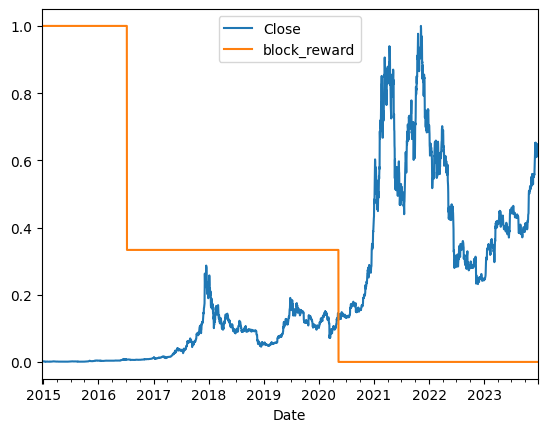

In [657]:
pd.DataFrame(minmax_scale(block_prices[['Close', 'block_reward']]), 
             index=block_prices.index, columns=['Close', 'block_reward']).plot()

```
Window for a week (7) to predict a horizon of 1 (multivariate time series)
WINDOW_SIZE & block_reward -> HORIZON

[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```


In [667]:
WINDOWE_SIZE = 7
HORIZON = 1

bitcoin_prices_windowed = block_prices.copy()



In [669]:
for i in range(WINDOWE_SIZE):
    bitcoin_prices_windowed[f'Price+{i+1}'] = block_prices['Close'].shift(periods=i+1)

In [670]:
bitcoin_prices_windowed.head()

,Close,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-12-22,331.885986,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-23,334.571991,25,331.885986,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-24,322.533997,25,334.571991,331.885986,NaN,NaN,NaN,NaN,NaN
2014-12-25,319.007996,25,322.533997,334.571991,331.885986,NaN,NaN,NaN,NaN
2014-12-26,327.924011,25,319.007996,322.533997,334.571991,331.885986,NaN,NaN,NaN


In [671]:
bitcoin_prices_windowed = bitcoin_prices_windowed.dropna()

In [672]:
bitcoin_prices_windowed.head()

,Close,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-12-29,312.670013,25,317.239014,315.863007,327.924011,319.007996,322.533997,334.571991,331.885986
2014-12-30,310.737000,25,312.670013,317.239014,315.863007,327.924011,319.007996,322.533997,334.571991
2014-12-31,320.192993,25,310.737000,312.670013,317.239014,315.863007,327.924011,319.007996,322.533997
2015-01-01,314.248993,25,320.192993,310.737000,312.670013,317.239014,315.863007,327.924011,319.007996
2015-01-02,315.032013,25,314.248993,320.192993,310.737000,312.670013,317.239014,315.863007,327.924011


In [673]:
x = bitcoin_prices_windowed.drop("Close", axis=1).astype('float32')
y = bitcoin_prices_windowed['Close'].astype('float64')

In [674]:
x.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-12-29,25.0,317.239014,315.863007,327.924011,319.007996,322.533997,334.571991,331.885986
2014-12-30,25.0,312.670013,317.239014,315.863007,327.924011,319.007996,322.533997,334.571991
2014-12-31,25.0,310.737000,312.670013,317.239014,315.863007,327.924011,319.007996,322.533997
2015-01-01,25.0,320.192993,310.737000,312.670013,317.239014,315.863007,327.924011,319.007996
2015-01-02,25.0,314.248993,320.192993,310.737000,312.670013,317.239014,315.863007,327.924011


In [675]:
y.head()

Date
2014-12-29    312.670013
2014-12-30    310.737000
2014-12-31    320.192993
2015-01-01    314.248993
2015-01-02    315.032013
Name: Close, dtype: float64

In [679]:
split_size = int(x.shape[0] * 0.8)

In [685]:
x_test, y_test = x[split_size:], y[split_size:]
x_test.shape, y_test.shape

((657, 8), (657,))

In [686]:
x_train, y_train = x[:split_size], y[:split_size]
x_train.shape, y_train.shape

((2624, 8), (2624,))

In [688]:
x_train.iloc[-1]

block_reward        6.250000
Price+1         39137.605469
Price+2         42451.789062
Price+3         43924.117188
Price+4         44354.636719
Price+5         43193.234375
Price+6         37709.785156
Price+7         39105.148438
Name: 2022-03-05 00:00:00, dtype: float32

In [690]:
x_test.iloc[0]

block_reward        6.250000
Price+1         39400.585938
Price+2         39137.605469
Price+3         42451.789062
Price+4         43924.117188
Price+5         44354.636719
Price+6         43193.234375
Price+7         37709.785156
Name: 2022-03-06 00:00:00, dtype: float32

## Model 6 : multivariate time series 

In [691]:
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON),
], name='model_6')

In [692]:
model_6.compile(loss='mae', optimizer=tf.keras.optimizers.Adam())

In [693]:
model_6.fit(x = x_train, 
            y = y_train, 
            validation_data=(x_test, y_test), 
            epochs=100,
            batch_size=128,
            callbacks=[create_model_checkpoint(model_6.name)],
           )

Epoch 1/100
14/21 [===================>..........] - ETA: 0s - loss: 9062.7861 INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 13s 293ms/step - loss: 6647.2993 - val_loss: 3168.8677
Epoch 2/100
14/21 [===================>..........] - ETA: 0s - loss: 1286.0590INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 6s 312ms/step - loss: 1207.7360 - val_loss: 1062.3950
Epoch 3/100
17/21 [=======================>......] - ETA: 0s - loss: 705.9559INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 3s 132ms/step - loss: 671.9072 - val_loss: 911.8574
Epoch 4/100
21/21 [==============================] - 0s 16ms/step - loss: 598.2058 - val_loss: 1024.9860
Epoch 5/100
17/21 [=======================>......] - ETA: 0s - loss: 567.2847INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 7s 333ms/step - loss: 566.4068 - val_loss: 818.9215
Epoch 6/100
10/21 [=============>................] - ETA: 0s - loss: 517.8577INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 2s 97ms/step - loss: 526.3481 - val_loss: 726.7321
Epoch 7/100
16/21 [=====================>........] - ETA: 0s - loss: 503.2886INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 2s 120ms/step - loss: 517.1028 - val_loss: 711.1040
Epoch 8/100
 9/21 [===========>..................] - ETA: 0s - loss: 520.0519INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 3s 143ms/step - loss: 505.7701 - val_loss: 694.2329
Epoch 9/100
13/21 [=================>............] - ETA: 0s - loss: 509.8154INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 2s 95ms/step - loss: 493.7553 - val_loss: 687.4188
Epoch 10/100
21/21 [==============================] - 0s 8ms/step - loss: 501.3351 - val_loss: 713.6926
Epoch 11/100
16/21 [=====================>........] - ETA: 0s - loss: 475.9647INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 2s 107ms/step - loss: 467.8970 - val_loss: 684.2380
Epoch 12/100
21/21 [==============================] - 0s 7ms/step - loss: 466.4361 - val_loss: 771.2064
Epoch 13/100
17/21 [=======================>......] - ETA: 0s - loss: 472.1887INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 2s 84ms/step - loss: 465.1044 - val_loss: 655.1694
Epoch 14/100
21/21 [==============================] - 0s 11ms/step - loss: 451.0792 - val_loss: 764.3144
Epoch 15/100
21/21 [==============================] - 0s 11ms/step - loss: 457.7496 - val_loss: 667.9124
Epoch 16/100
17/21 [=======================>......] - ETA: 0s - loss: 436.9200INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 2s 89ms/step - loss: 434.2922 - val_loss: 622.1692
Epoch 17/100
21/21 [==============================] - 0s 7ms/step - loss: 432.4994 - val_loss: 655.5874
Epoch 18/100
19/21 [==========================>...] - ETA: 0s - loss: 438.5365INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 2s 105ms/step - loss: 442.3511 - val_loss: 610.4803
Epoch 19/100
14/21 [===================>..........] - ETA: 0s - loss: 457.7445INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 2s 86ms/step - loss: 433.2093 - val_loss: 608.6967
Epoch 20/100
21/21 [==============================] - 0s 9ms/step - loss: 431.7776 - val_loss: 817.1148
Epoch 21/100
15/21 [====================>.........] - ETA: 0s - loss: 430.2530INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 2s 77ms/step - loss: 426.7931 - val_loss: 591.4923
Epoch 22/100
21/21 [==============================] - 0s 7ms/step - loss: 411.1876 - val_loss: 632.8260
Epoch 23/100
21/21 [==============================] - 0s 12ms/step - loss: 410.2286 - val_loss: 625.2142
Epoch 24/100
17/21 [=======================>......] - ETA: 0s - loss: 416.7680INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 1s 72ms/step - loss: 402.6376 - val_loss: 590.1779
Epoch 25/100
18/21 [========================>.....] - ETA: 0s - loss: 410.3994INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 2s 87ms/step - loss: 402.5821 - val_loss: 583.9223
Epoch 26/100
15/21 [====================>.........] - ETA: 0s - loss: 388.6582INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 1s 74ms/step - loss: 422.5425 - val_loss: 580.8353
Epoch 27/100
16/21 [=====================>........] - ETA: 0s - loss: 431.5810INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 2s 76ms/step - loss: 429.9470 - val_loss: 568.9731
Epoch 28/100
21/21 [==============================] - 0s 13ms/step - loss: 405.4412 - val_loss: 650.9453
Epoch 29/100
12/21 [================>.............] - ETA: 0s - loss: 407.0805INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 2s 104ms/step - loss: 396.2575 - val_loss: 562.8897
Epoch 30/100
21/21 [==============================] - 0s 6ms/step - loss: 393.8973 - val_loss: 575.4658
Epoch 31/100
17/21 [=======================>......] - ETA: 0s - loss: 373.6060INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 2s 80ms/step - loss: 387.1736 - val_loss: 558.9984
Epoch 32/100
21/21 [==============================] - 0s 5ms/step - loss: 387.4784 - val_loss: 562.7094
Epoch 33/100
21/21 [==============================] - 0s 6ms/step - loss: 390.5558 - val_loss: 563.3809
Epoch 34/100
21/21 [==============================] - 0s 6ms/step - loss: 388.3912 - val_loss: 765.2815
Epoch 35/100
21/21 [==============================] - 0s 5ms/step - loss: 406.3433 - val_loss: 776.7551
Epoch 36/100
19/21 [==========================>...] - ETA: 0s - loss: 414.6452INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 1s 71ms/step - loss: 414.2389 - val_loss: 545.0132
Epoch 37/100
21/21 [==============================] - 0s 14ms/step - loss: 387.1592 - val_loss: 552.3644
Epoch 38/100
21/21 [==============================] - 0s 10ms/step - loss: 377.9546 - val_loss: 648.2570
Epoch 39/100
21/21 [==============================] - 0s 6ms/step - loss: 399.1657 - val_loss: 642.1053
Epoch 40/100
21/21 [==============================] - 0s 5ms/step - loss: 442.7677 - val_loss: 927.7631
Epoch 41/100
21/21 [==============================] - 0s 6ms/step - loss: 385.5349 - val_loss: 566.7859
Epoch 42/100
21/21 [==============================] - 0s 6ms/step - loss: 398.2824 - val_loss: 832.8588
Epoch 43/100
17/21 [=======================>......] - ETA: 0s - loss: 387.9324INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 2s 82ms/step - loss: 383.1954 - val_loss: 542.8900
Epoch 44/100
21/21 [==============================] - 0s 7ms/step - loss: 378.1665 - val_loss: 545.3595
Epoch 45/100
21/21 [==============================] - 0s 6ms/step - loss: 369.3856 - val_loss: 618.0669
Epoch 46/100
21/21 [==============================] - 0s 8ms/step - loss: 369.7902 - val_loss: 546.1674
Epoch 47/100
21/21 [==============================] - 0s 16ms/step - loss: 374.1091 - val_loss: 546.3036
Epoch 48/100
13/21 [=================>............] - ETA: 0s - loss: 370.1071INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 2s 90ms/step - loss: 370.4083 - val_loss: 526.4948
Epoch 49/100
21/21 [==============================] - 0s 11ms/step - loss: 363.9492 - val_loss: 564.3893
Epoch 50/100
14/21 [===================>..........] - ETA: 0s - loss: 356.2531INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 2s 113ms/step - loss: 376.7745 - val_loss: 522.3096
Epoch 51/100
21/21 [==============================] - 0s 6ms/step - loss: 364.9366 - val_loss: 530.6451
Epoch 52/100
21/21 [==============================] - 0s 7ms/step - loss: 357.9756 - val_loss: 553.3896
Epoch 53/100
21/21 [==============================] - 0s 8ms/step - loss: 363.2312 - val_loss: 642.3301
Epoch 54/100
21/21 [==============================] - 0s 12ms/step - loss: 366.3497 - val_loss: 643.1984
Epoch 55/100
21/21 [==============================] - 0s 10ms/step - loss: 376.9686 - val_loss: 553.1125
Epoch 56/100
21/21 [==============================] - 0s 6ms/step - loss: 361.8811 - val_loss: 562.7490
Epoch 57/100
21/21 [==============================] - 0s 6ms/step - loss: 396.2652 - val_loss: 744.2789
Epoch 58/100
21/21 [==============================] - 0s 6ms/step - loss: 380.8735 - val_loss: 562.5759
Epoch 59/100
21/21 [==============================] - 0s 6ms/step - loss:

INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 1s 70ms/step - loss: 362.7153 - val_loss: 512.8997
Epoch 61/100
21/21 [==============================] - 0s 5ms/step - loss: 355.6886 - val_loss: 609.8911
Epoch 62/100
21/21 [==============================] - 0s 6ms/step - loss: 362.6629 - val_loss: 524.7004
Epoch 63/100
21/21 [==============================] - 0s 10ms/step - loss: 363.5197 - val_loss: 513.3767
Epoch 64/100
21/21 [==============================] - 0s 6ms/step - loss: 359.0245 - val_loss: 595.4321
Epoch 65/100
21/21 [==============================] - 0s 7ms/step - loss: 369.0621 - val_loss: 582.8362
Epoch 66/100
21/21 [==============================] - 0s 9ms/step - loss: 382.5362 - val_loss: 614.9179
Epoch 67/100
21/21 [==============================] - 0s 13ms/step - loss: 355.0914 - val_loss: 514.7465
Epoch 68/100
21/21 [==============================] - 0s 6ms/step - loss: 378.1803 - val_loss: 891.1450
Epoch 69/100
17/21 [=======================>......] - ETA: 0s - loss: 367.

INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 2s 78ms/step - loss: 366.5016 - val_loss: 510.6889
Epoch 70/100
10/21 [=============>................] - ETA: 0s - loss: 378.2474INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 2s 113ms/step - loss: 363.3160 - val_loss: 509.0612
Epoch 71/100
21/21 [==============================] - 0s 6ms/step - loss: 357.2759 - val_loss: 693.7584
Epoch 72/100
21/21 [==============================] - 0s 6ms/step - loss: 372.8649 - val_loss: 752.7916
Epoch 73/100
21/21 [==============================] - 0s 6ms/step - loss: 360.0974 - val_loss: 518.6161
Epoch 74/100
21/21 [==============================] - 0s 14ms/step - loss: 364.8208 - val_loss: 569.0926
Epoch 75/100
21/21 [==============================] - 0s 6ms/step - loss: 376.1861 - val_loss: 744.6902
Epoch 76/100
21/21 [==============================] - 0s 8ms/step - loss: 356.1417 - val_loss: 533.8026
Epoch 77/100
21/21 [==============================] - 0s 9ms/step - loss: 354.6011 - val_loss: 526.9662
Epoch 78/100
21/21 [==============================] - 0s 11ms/step - loss: 376.7242 - val_loss: 640.0169
Epoch 79/100
21/21 [==============================] - 0s 16ms/step - loss

INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 1s 71ms/step - loss: 370.2173 - val_loss: 504.1748
Epoch 82/100
21/21 [==============================] - 0s 10ms/step - loss: 351.0702 - val_loss: 575.4677
Epoch 83/100
21/21 [==============================] - 0s 7ms/step - loss: 357.1977 - val_loss: 638.3976
Epoch 84/100
21/21 [==============================] - 0s 7ms/step - loss: 374.8290 - val_loss: 658.1253
Epoch 85/100
21/21 [==============================] - 0s 16ms/step - loss: 386.7724 - val_loss: 510.5202
Epoch 86/100
21/21 [==============================] - 0s 6ms/step - loss: 355.8948 - val_loss: 583.8156
Epoch 87/100
21/21 [==============================] - 0s 7ms/step - loss: 366.8441 - val_loss: 507.9713
Epoch 88/100
17/21 [=======================>......] - ETA: 0s - loss: 357.0277INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 2s 87ms/step - loss: 351.5586 - val_loss: 502.9434
Epoch 89/100
21/21 [==============================] - 0s 6ms/step - loss: 357.8698 - val_loss: 631.4177
Epoch 90/100
21/21 [==============================] - 0s 6ms/step - loss: 362.4598 - val_loss: 621.3243
Epoch 91/100
15/21 [====================>.........] - ETA: 0s - loss: 354.8150INFO:tensorflow:Assets written to: model_experiments\model_6\assets


INFO:tensorflow:Assets written to: model_experiments\model_6\assets


21/21 [==============================] - 2s 98ms/step - loss: 351.8973 - val_loss: 502.4654
Epoch 92/100
21/21 [==============================] - 0s 7ms/step - loss: 347.0061 - val_loss: 563.9680
Epoch 93/100
21/21 [==============================] - 0s 13ms/step - loss: 374.7035 - val_loss: 703.2896
Epoch 94/100
21/21 [==============================] - 0s 7ms/step - loss: 385.1320 - val_loss: 834.8640
Epoch 95/100
21/21 [==============================] - 0s 7ms/step - loss: 446.9022 - val_loss: 564.5997
Epoch 96/100
21/21 [==============================] - 0s 9ms/step - loss: 404.3303 - val_loss: 862.0652
Epoch 97/100
21/21 [==============================] - 0s 12ms/step - loss: 424.7841 - val_loss: 806.0342
Epoch 98/100
21/21 [==============================] - 0s 16ms/step - loss: 385.3220 - val_loss: 535.6498
Epoch 99/100
21/21 [==============================] - 0s 10ms/step - loss: 351.7539 - val_loss: 504.7114
Epoch 100/100
21/21 [==============================] - 0s 9ms/step - los

In [696]:
model_6 = tf.keras.models.load_model("model_experiments/model_6")
model_6.evaluate(x_test)

21/21 [==============================] - 0s 2ms/step - loss: 0.0000e+00


0.0

In [697]:
pred = model_6.predict(x_test)

21/21 [==============================] - 0s 2ms/step


In [706]:
model_6_results = evaluate_preds(y_test, tf.squeeze(pred))

## Model 8: Creating an ensemble (stacking different models together)

In [711]:
def get_ensembles_models(horizon=HORIZON,
                         window_size=WINDOWE_SIZE, 
                         x_train=x_train, 
                         y_train=y_train, 
                         validation_data=(x_test, y_test),
                         n_iters=10, loss_fncs=["mae", "mse", "mape"], epochs=100):
    """
    Creating ensembles of models for n_iters * len(loss_fncs)
    """
    ensembles_models = []
    for i in range(n_iters):
        for loss in loss_fncs:
            model = Sequential([
                layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
                layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
                layers.Dense(horizon),
            ])
            model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(),metrics = ['mae', 'mse'])
            model.fit(x = x_train, 
                      verbose=0,
                      y=y_train, 
                      validation_data=validation_data, 
                      epochs=epochs, 
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                                 tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
            ensembles_models.append(model)
    return ensembles_models

In [712]:
ensemble_models = get_ensembles_models(n_iters=10, epochs=1000) 


Epoch 205: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 323: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 423: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 290: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 390: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 178: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 327: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 427: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 364: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 542: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 642: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 274: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 374: ReduceLROnPlateau reducing l

In [720]:
def ensemble_prediction(models, x_test=x_test):
    ensemble_preds = []
    for model in models:
        ensemble_preds.append(model.predict(x_test))
    return tf.constant(tf.squeeze(ensemble_preds))

In [721]:
ensembles_preds = ensemble_prediction(ensemble_models)

21/21 [==============================] - 0s 2ms/step


In [722]:
ensembles_preds

<tf.Tensor: shape=(30, 657), dtype=float32, numpy=
array([[39418.395, 38450.14 , 38033.43 , ..., 42271.113, 43570.348,
        43838.734],
       [39652.727, 38185.13 , 37979.27 , ..., 42375.3  , 43494.74 ,
        43948.29 ],
       [39478.707, 38627.65 , 38182.14 , ..., 42326.05 , 43567.547,
        43861.96 ],
       ...,
       [39838.29 , 38402.297, 37826.62 , ..., 42285.41 , 43531.406,
        43909.703],
       [39591.08 , 38384.945, 37853.53 , ..., 42212.83 , 43555.2  ,
        43930.85 ],
       [39360.145, 38547.39 , 38161.406, ..., 42298.938, 43608.227,
        43858.695]], dtype=float32)>

({'mae': 499.8258,
  'mse': 587244.3,
  'rmse': 766.31866,
  'mape': 1.8392957,
  'mase': 0.9986825},
 {'mae': 502.4655,
  'mse': 593389.56,
  'rmse': 770.3178,
  'mape': 1.8527396,
  'mase': 1.0039568},
 {'mae': 501.56888,
  'mse': 592033.1,
  'rmse': 501.56888,
  'mape': 1.8540635,
  'mase': 1.0021652},
 {'mae': 500.10587,
  'mse': 588840.7,
  'rmse': 767.35956,
  'mape': 1.8488324,
  'mase': 0.99924207},
 {'mae': 8246.829,
  'mse': 110514410.0,
  'rmse': 10061.171,
  'mape': 31.827276,
  'mase': 16.712597},
 {'mae': 511.73196,
  'mse': 601740.3,
  'rmse': 775.71924,
  'mape': 1.9157727,
  'mase': 1.0382919},
 {'mae': 541.6064,
  'mse': 634013.0,
  'rmse': 796.2493,
  'mape': 1.9863317,
  'mase': 1.0821626})

In [728]:
ensembl_results = evaluate_preds(y_test,np.median(ensembles_preds, axis=0) )

In [729]:
ensembl_results

{'mae': 499.8258,
 'mse': 587244.3,
 'rmse': 766.31866,
 'mape': 1.8392957,
 'mase': 0.9986825}

In [730]:
ensembles_preds.shape

TensorShape([30, 657])

In [735]:
def get_upper_lower(preds):
    std = tf.math.reduce_std(pred, axis=0)
    interval= 1.96 * std
    print(interval)
    pred_mean = tf.reduce_mean(preds, axis=0)
    lower, upper = pred_mean -interval, pred_mean + interval
    return lower,upper

In [736]:
lower, upper =  get_upper_lower(ensembles_preds)

tf.Tensor([14653.624], shape=(1,), dtype=float32)


In [738]:
lower[0] , upper[0]

(<tf.Tensor: shape=(), dtype=float32, numpy=24703.895>,
 <tf.Tensor: shape=(), dtype=float32, numpy=54011.145>)

In [741]:
y_test

Date
2022-03-06    38419.984375
2022-03-07    38062.039063
2022-03-08    38737.269531
2022-03-09    41982.925781
2022-03-10    39437.460938
                  ...     
2023-12-18    42623.539063
2023-12-19    42270.527344
2023-12-20    43652.250000
2023-12-21    43869.152344
2023-12-22    43652.902344
Name: Close, Length: 657, dtype: float64

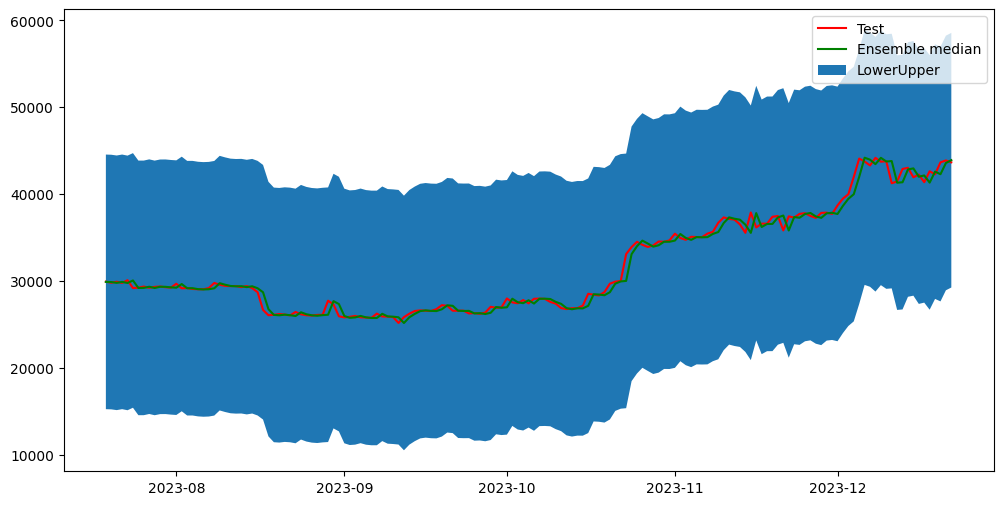

In [756]:
offset = 500
plt.figure(figsize=(12, 6))
plt.plot(y_test[offset:],  'r',label='Test')
plt.plot(y_test.index[offset:],np.median(ensembles_preds, axis=0)[offset:],'g', label='Ensemble median')
plt.fill_between(y_test.index[offset:],(lower[offset:]), (upper[offset:]), label='LowerUpper')

plt.legend()

In [743]:
ensembles_preds

<tf.Tensor: shape=(30, 657), dtype=float32, numpy=
array([[39418.395, 38450.14 , 38033.43 , ..., 42271.113, 43570.348,
        43838.734],
       [39652.727, 38185.13 , 37979.27 , ..., 42375.3  , 43494.74 ,
        43948.29 ],
       [39478.707, 38627.65 , 38182.14 , ..., 42326.05 , 43567.547,
        43861.96 ],
       ...,
       [39838.29 , 38402.297, 37826.62 , ..., 42285.41 , 43531.406,
        43909.703],
       [39591.08 , 38384.945, 37853.53 , ..., 42212.83 , 43555.2  ,
        43930.85 ],
       [39360.145, 38547.39 , 38161.406, ..., 42298.938, 43608.227,
        43858.695]], dtype=float32)>

In [782]:
ensembles_preds = ensemble_prediction(ensemble_models,x_test.iloc[-1:])

1/1 [==============================] - 0s 35ms/step


In [783]:
lower, upper =  get_upper_lower(ensembles_preds)

tf.Tensor([14653.624], shape=(1,), dtype=float32)


In [784]:
x_test.iloc[-1:]

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2023-12-22,6.25,43869.152344,43652.25,42270.527344,42623.539062,41364.664062,42240.117188,41929.757812


In [785]:
lower, upper

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([29242.121], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([58549.37], dtype=float32)>)

In [786]:
np.median(ensembles_preds)

43902.953

In [788]:
np.mean(ensembles_preds)

43895.75

In [789]:
max(ensembles_preds), min(ensembles_preds)

(<tf.Tensor: shape=(), dtype=float32, numpy=44035.027>,
 <tf.Tensor: shape=(), dtype=float32, numpy=43757.438>)

## Predict the future

In [797]:
bitcoin_prices_windowed.iloc[1:].shape[0]

3280

In [795]:
bitcoin_prices_windowed.iloc[1:].iloc[bitcoin_prices_windowed.iloc[1:].shape[0]+1]

,Close,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-12-30,310.737000,25,312.670013,317.239014,315.863007,327.924011,319.007996,322.533997,334.571991
2014-12-31,320.192993,25,310.737000,312.670013,317.239014,315.863007,327.924011,319.007996,322.533997
2015-01-01,314.248993,25,320.192993,310.737000,312.670013,317.239014,315.863007,327.924011,319.007996
2015-01-02,315.032013,25,314.248993,320.192993,310.737000,312.670013,317.239014,315.863007,327.924011
2015-01-03,281.082001,25,315.032013,314.248993,320.192993,310.737000,312.670013,317.239014,315.863007
...,...,...,...,...,...,...,...,...,...
2023-12-18,42623.539063,6.25,41364.664063,42240.117188,41929.757813,43023.972656,42890.742188,41450.222656,41243.832031
2023-12-19,42270.527344,6.25,42623.539063,41364.664063,42240.117188,41929.757813,43023.972656,42890.742188,41450.222656
2023-12-20,43652.250000,6.25,42270.527344,42623.539063,41364.664063,42240.117188,41929.757813,43023.972656,42890.742188


In [792]:
bitcoin_prices_windowed.tail()

,Close,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2023-12-18,42623.539063,6.25,41364.664063,42240.117188,41929.757813,43023.972656,42890.742188,41450.222656,41243.832031
2023-12-19,42270.527344,6.25,42623.539063,41364.664063,42240.117188,41929.757813,43023.972656,42890.742188,41450.222656
2023-12-20,43652.250000,6.25,42270.527344,42623.539063,41364.664063,42240.117188,41929.757813,43023.972656,42890.742188
2023-12-21,43869.152344,6.25,43652.250000,42270.527344,42623.539063,41364.664063,42240.117188,41929.757813,43023.972656
2023-12-22,43652.902344,6.25,43869.152344,43652.250000,42270.527344,42623.539063,41364.664063,42240.117188,41929.757813


In [804]:
# Train model on entire data to make prediction for the next day 
X_all = bitcoin_prices_windowed.drop(["Close", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Close"].to_numpy()
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [805]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0) # don't print out anything, we've seen this all before

In [809]:
INTO_FUTURE = 14
def make_future_forecast(model, x, into_future=INTO_FUTURE, horizon=HORIZON, window_size=WINDOW_SIZE):
    past_data = x[-window_size:]
    forcast_into_future = []
    for i in range(into_future):
        
        next_day_forcast = model.predict(tf.expand_dims(past_data, axis=0))
        forcast_into_future.append(tf.squeeze(next_day_forcast).numpy())
        past_data = np.append(past_data, next_day_forcast)[-WINDOW_SIZE:]
    return forcast_into_future

In [811]:
focast = make_future_forecast(model_9,y_all )

1/1 [==============================] - 0s 50ms/step


In [875]:
focast

[42462.84,
 42454.684,
 43165.69,
 43328.914,
 43916.88,
 43902.38,
 43510.395,
 43034.63,
 43297.12,
 43754.902,
 43935.965,
 44144.766,
 44029.195,
 43770.582]

In [894]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  return np.arange( np.datetime64(start_date), into_future,
          dtype='datetime64[D]')

In [895]:
# Get next two weeks of timesteps
last_timestep = bitcoin_prices_windowed.iloc[-1:].index
next_time_steps = get_future_dates(start_date=np.datetime_as_string(last_timestep)[0], 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
       '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
       '2023-12-30', '2023-12-31', '2024-01-01', '2024-01-02',
       '2024-01-03', '2024-01-04'], dtype='datetime64[D]')

In [906]:
np.insert(focast, 0, bitcoin_price.values[-1])


array([43652.902, 42462.84 , 42454.684, 43165.69 , 43328.914, 43916.88 ,
       43902.38 , 43510.395, 43034.63 , 43297.12 , 43754.902, 43935.965,
       44144.766, 44029.195, 43770.582], dtype=float32)

Text(0.5, 1.0, 'Bitcoin Price in The next 14 days')

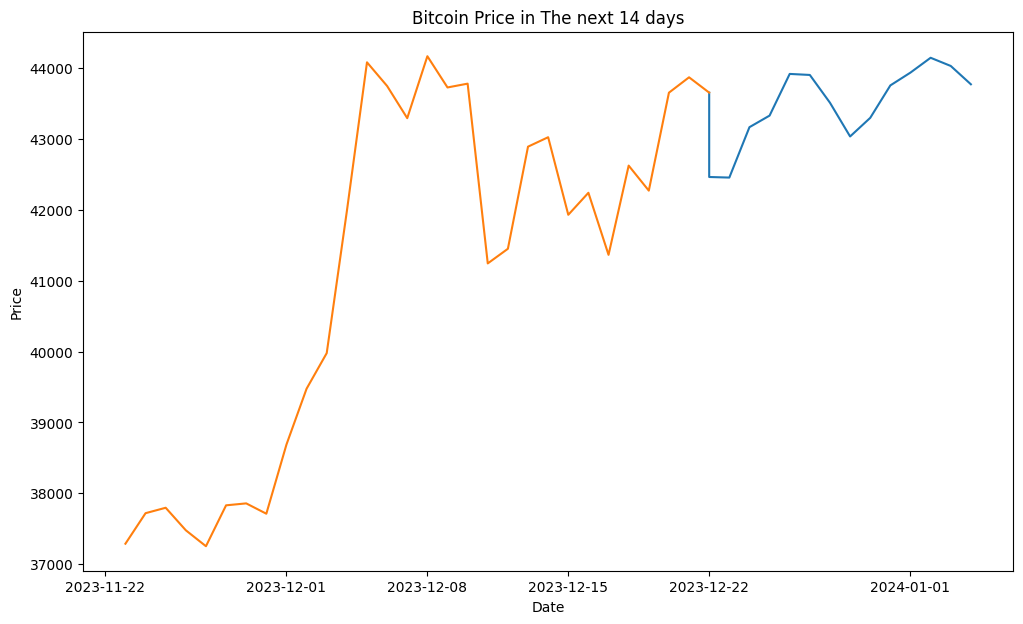

In [908]:
plt.figure(figsize=(12, 7))
plt.plot(np.insert(next_time_steps, 0, last_timestep)
,np.insert(focast, 0, bitcoin_price.values[-1])
, label='Next14Days')

plt.plot(bitcoin_price.index[-30:],bitcoin_price.values[-30:], label='Past')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Price in The next 14 days')

## Compare the models

In [917]:
all_results = pd.DataFrame([ensembl_results, 
                            model_6_results, 
                            model_5_results,
                            model_4_results,
                            model_3_resuls, 
                            model_2_results, 
                            model_1_results], index= ['model_7_ensemble', 'model_6_ultivariate', 'model_5_LSTM', 'model_4_Conv1D','model_3', 'model_2', 'model_1'])

<AxesSubplot: >

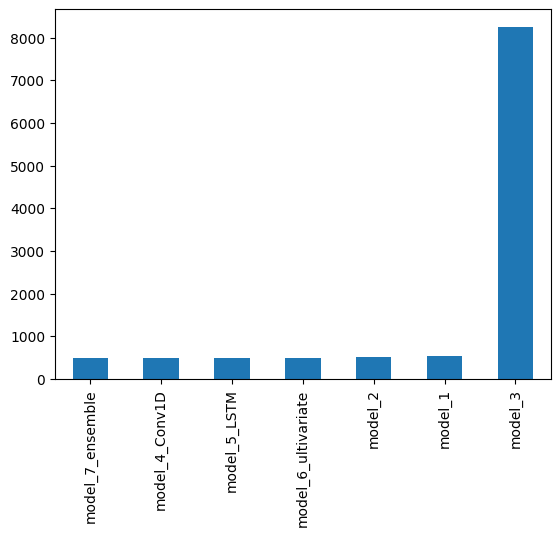

In [920]:
all_results['mae'].sort_values().plot(kind='bar')